In [1]:
import pandas as pd; pd.set_option('max_rows', 1000)
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['font.family'] = 'Malgun Gothic'
from matplotlib import cm
import seaborn as sns; sns.set(font='Malgun Gothic'); 
import warnings; warnings.filterwarnings(action='ignore')

import yfinance as yf # 야후 파이낸스
import bt             # 백테스트 라이브러리
import pyfolio as pf  # 백테스트 시각화 라이브러리
import talib          # 보조지표 라이브러리

# 변수 정의

In [2]:
# 데이터 수집 기간 및 베이스라인 : 
# , 백테스팅을 위해 여분
start_date_pad = '2003-07-29'
end_date_pad   = '2021-10-29'

# 학습 기간
start_date_train = '2003-09-29'
end_date_train   = '2011-09-28'

# 예측 기간
start_date_pred = '2011-09-29'
end_date_pred   = '2021-09-28'

# 백테스트 기간 : HV_resid 활용을 위해 20일 여분
start_date_bt = '2011-09-29'
end_date_bt   = '2021-08-28'

# 주가 데이터 수집

In [3]:
# 지수
indice_tickers = ['^KS11', '^GSPC', '^IXIC',  '^N225',  '^HSI',     '^FCHI', '^GDAXI']
indice_names   = ['kospi', 'sp500', 'nasdaq', 'nikkei', 'hangseng', 'cac',   'dax']

# 지수 추종 ETF   : 코스피,   S&P500,  나스닥,   닛케이,     홍콩,       프랑스,   독일,   미 국채
etf_tickers    = ['EWY',   'SPY',   'QQQ',    'EWJ',    'EWH',      'EWQ',   'EWG', 'AGG']
etf_names      = ['kospi', 'sp500', 'nasdaq', 'nikkei', 'hangseng', 'cac',   'dax', 'agg']

# 지수 OHLCV
indice = yf.download(indice_tickers, start=start_date_pad, end=end_date_pad)
# 지수 추종 OHLCV
etf    = yf.download(etf_tickers, start=start_date_pad, end=end_date_pad)

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  8 of 8 completed


In [4]:
etf['Adj Close']

AGG        EWG        EWH        EWJ        EWQ        EWY  \
Date                                                                            
2003-07-28         NaN   8.589716   4.700956  24.707077  10.765283  17.662931   
2003-07-29         NaN   8.562788   4.724345  24.390314  10.625309  17.903791   
2003-07-30         NaN   8.475276   4.712650  23.883503  10.695294  17.767305   
2003-07-31         NaN   8.549324   4.765273  24.073559  10.708022  17.422075   
2003-08-01         NaN   8.414689   4.741884  23.788483  10.517147  17.767305   
...                ...        ...        ...        ...        ...        ...   
2021-10-22  113.880913  33.779999  24.680000  68.419998  38.970001  80.360001   
2021-10-25  113.990738  33.810001  24.760000  68.449997  38.639999  81.440002   
2021-10-26  114.200409  33.990002  24.700001  68.459999  38.849998  82.029999   
2021-10-27  114.579819  33.840000  24.480000  67.959999  38.750000  80.989998   
2021-10-28  114.489952  34.080002  24.600000  68.500000  39.439999  81.089996   

                   QQQ         SPY  
Date                                
2003-07-28   27.658089   69.914574  
2003-07-29   27.449936   69.592491  
2003-07-30   27.250450   69.424461  
2003-07-31   27.580030   69.585480  
2003-08-01   27.285143   68.969383  
...                ...         ...  
2021-10-22  374.100006  453.119995  
2021-10-25  377.929993  455.549988  
2021-10-26  379.119995  455.959991  
2021-10-27  380.000000  453.940002  
2021-10-28  384.220001  458.320007  

[4598 rows x 8 columns]

# 지수와 지수 추종 ETF의 상관관계

In [5]:
pd.concat([indice['Adj Close'], etf['Adj Close']], axis=1).corr().iloc[:7, -7:]

# 코스피 : 0.977490
# sp500 : 0.998325
# 나스닥 : 0.998903
# 닛케이 : 0.976603
# 항셍   : 0.906356
# 프랑스 : 0.883865
# 독일   : 0.952550

EWG       EWH       EWJ       EWQ       EWY       QQQ       SPY
^FCHI   0.761684  0.652673  0.891918  0.883865  0.665407  0.657152  0.710768
^GDAXI  0.952550  0.972969  0.902571  0.908758  0.889398  0.886084  0.938418
^GSPC   0.867086  0.918053  0.932788  0.900267  0.838659  0.981866  0.998325
^HSI    0.915971  0.906356  0.755839  0.851663  0.890112  0.661726  0.724927
^IXIC   0.821541  0.884684  0.900776  0.861896  0.822208  0.998903  0.991702
^KS11   0.921939  0.913960  0.783142  0.849054  0.977490  0.796176  0.821399
^N225   0.841868  0.831728  0.976603  0.906331  0.760570  0.875070  0.913039

# 글라이드 패스 함수

In [6]:
def makeGlidePath(etf_ohlcv, glide_weight, risk_weight, start_year):
    
    # 날짜, 위험자산 비중 데이터프레임
    df = pd.DataFrame(
        {
            'Date': [str(year) + '-09-29' for year in range(start_year, 2022)], 
            'RA'  : glide_weight
        }
    )
    
    # 장이 열린 날짜로 조정
    df['Date'] = df.apply(lambda x: etf_ohlcv['Adj Close'].index[etf_ohlcv['Adj Close'].index.get_loc(x['Date'], method='nearest')], axis=1)
    
    # 비위험자산 비중
    df['AGG'] = 1 - df['RA']
    
    # 위험자산 비중
    risk_etfs = ['EWG', 'EWH', 'EWJ', 'EWQ', 'EWY', 'QQQ', 'SPY']
    for risk_etf, weight in zip(risk_etfs, risk_weight):
        df[risk_etf] = df['RA'] * weight
    
    df.set_index('Date', inplace=True)
    df.index = pd.to_datetime(['2003-09-29', '2004-09-29', '2005-09-29', '2006-09-29','2007-09-28', '2008-09-29', '2009-09-29', '2010-09-29','2011-09-29', '2012-09-28', '2013-09-30', '2014-09-29','2015-09-29', '2016-09-29', '2017-09-29', '2018-09-28','2019-09-30', '2020-09-29', '2021-08-28'])
    df.drop('RA', axis=1, inplace=True)
    
    return df

# baseline 변동성

In [7]:
# 위험자산내 비중 [독일,   홍콩,  일본,   프랑스, 한국,   S&P,   나스닥]
risk_weight   = [.0250, .0250, .0375, .0375, .2500, .2000, .4250]

# baseline 변동성의 글라이드 패스 : 안전자산 없이 위험자산으로만 구성(가장 큰 변동성 확인 가능)
gw_baseline = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
gp_baseline = makeGlidePath(etf, gw_baseline, risk_weight, start_year=int(start_date_pad[:4]))
gp_baseline

AGG    EWG    EWH     EWJ     EWQ   EWY  QQQ    SPY
2003-09-29    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2004-09-29    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2005-09-29    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2006-09-29    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2007-09-28    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2008-09-29    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2009-09-29    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2010-09-29    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2011-09-29    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2012-09-28    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2013-09-30    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2014-09-29    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2015-09-29    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2016-09-29    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2017-09-29    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2018-09-28    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2019-09-30    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2020-09-29    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425
2021-08-28    0  0.025  0.025  0.0375  0.0375  0.25  0.2  0.425

In [8]:
# 백테스팅의 데이터
baseline_data = etf['Adj Close'].loc[start_date_pad:]

# 백테스팅 전략
baseline_strategy = bt.Strategy(
    'baseline', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_baseline), 
        bt.algos.Rebalance(), 
    

# 백테스트
baseline_backtest = bt.Backtest(strategy=baseline_strategy, data=baseline_data)
baseline_result   = bt.run(baseline_backtest)

In [9]:
baseline_result.prices

baseline
2003-07-28  100.000000
2003-07-29  100.000000
2003-07-30  100.000000
2003-07-31  100.000000
2003-08-01  100.000000
...                ...
2021-10-22  672.347294
2021-10-25  677.330120
2021-10-26  679.394621
2021-10-27  675.912681
2021-10-28  681.364586

[4598 rows x 1 columns]

In [10]:
baseline_result.stats # 백테스트 요약 결과

baseline
start                  2003-07-28 00:00:00
end                    2021-10-28 00:00:00
rf                                     0.0
total_return                      5.813646
cagr                              0.110853
max_drawdown                      -0.58885
calmar                            0.188253
mtd                               0.048472
three_month                       0.004992
six_month                         0.033975
ytd                               0.134459
one_year                          0.360683
three_year                        0.214745
five_year                         0.173026
ten_year                          0.134245
incep                             0.110853
daily_sharpe                      0.609809
daily_sortino                     0.957175
daily_mean                        0.126856
daily_vol                         0.208026
daily_skew                        0.073526
daily_kurt                       16.080381
best_day                          0.160523
worst_day                        -0.122482
monthly_sharpe                    0.721098
monthly_sortino                   1.218557
monthly_mean                      0.119409
monthly_vol                       0.165593
monthly_skew                     -0.509475
monthly_kurt                      1.935971
best_month                        0.136758
worst_month                      -0.198647
yearly_sharpe                     0.660965
yearly_sortino                     1.20666
yearly_mean                       0.123314
yearly_vol                        0.186567
yearly_skew                      -1.463995
yearly_kurt                        3.83629
best_year                         0.424405
worst_year                       -0.430743
avg_drawdown                     -0.021564
avg_drawdown_days                26.324444
avg_up_month                      0.036541
avg_down_month                   -0.036251
win_year_perc                     0.833333
twelve_month_win_perc             0.808612

## 백테스트 결과 시각화

In [11]:
%matplotlib inline
# baseline_result.prices.to_drawdown_series().plot() # MDD(최대낙폭)

In [12]:
baseline_returns = baseline_result.prices.to_returns().iloc[1:, 0]
# baseline_returns.plot() # 일별 수익률

In [13]:
# pyfolio 종합 plot
# pf.create_full_tear_sheet(baseline_returns)

In [14]:
# pf.plot_drawdown_periods(returns=baseline_returns, top=10)

In [15]:
# pf.plot_returns(baseline_returns)

In [16]:
# pf.plot_annual_returns(baseline_returns)

In [17]:
# pf.plot_drawdown_underwater(baseline_returns)

In [18]:
# pf.plot_monthly_returns_dist(baseline_returns)

In [19]:
# pf.plot_monthly_returns_heatmap(baseline_returns)

In [20]:
# pf.plot_monthly_returns_timeseries(baseline_returns)

In [21]:
# pf.plot_return_quantiles(baseline_returns)

In [22]:
# pf.plot_rolling_returns(baseline_returns)

In [23]:
# pf.plot_rolling_sharpe(baseline_returns)

In [24]:
# pf.plot_rolling_volatility(baseline_returns)

## baseline 변동성 데이터

In [25]:
baseline_hv = baseline_result.prices
baseline_hv['HV']          = baseline_hv.iloc[:, 0].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252)
baseline_hv['HV_pred_5']   = baseline_hv.iloc[:, 1].shift(-5)
baseline_hv['HV_pred_10']  = baseline_hv.iloc[:, 1].shift(-10)
baseline_hv['HV_pred_15']  = baseline_hv.iloc[:, 1].shift(-15)
baseline_hv['HV_pred_20']  = baseline_hv.iloc[:, 1].shift(-20)
baseline_hv['HV_resid_5']  = baseline_hv.iloc[:, 1].diff(-5)
baseline_hv['HV_resid_10'] = baseline_hv.iloc[:, 1].diff(-10)
baseline_hv['HV_resid_15'] = baseline_hv.iloc[:, 1].diff(-15)
baseline_hv['HV_resid_20'] = baseline_hv.iloc[:, 1].diff(-20)

baseline_hv

baseline        HV  HV_pred_5  HV_pred_10  HV_pred_15  \
2003-07-28  100.000000       NaN        0.0         0.0         0.0   
2003-07-29  100.000000  0.000000        0.0         0.0         0.0   
2003-07-30  100.000000  0.000000        0.0         0.0         0.0   
2003-07-31  100.000000  0.000000        0.0         0.0         0.0   
2003-08-01  100.000000  0.000000        0.0         0.0         0.0   
...                ...       ...        ...         ...         ...   
2021-10-22  672.347294  0.140719        NaN         NaN         NaN   
2021-10-25  677.330120  0.142808        NaN         NaN         NaN   
2021-10-26  679.394621  0.114911        NaN         NaN         NaN   
2021-10-27  675.912681  0.116604        NaN         NaN         NaN   
2021-10-28  681.364586  0.115815        NaN         NaN         NaN   

            HV_pred_20  HV_resid_5  HV_resid_10  HV_resid_15  HV_resid_20  
2003-07-28         0.0         NaN          NaN          NaN          NaN  
2003-07-29         0.0         0.0          0.0          0.0          0.0  
2003-07-30         0.0         0.0          0.0          0.0          0.0  
2003-07-31         0.0         0.0          0.0          0.0          0.0  
2003-08-01         0.0         0.0          0.0          0.0          0.0  
...                ...         ...          ...          ...          ...  
2021-10-22         NaN         NaN          NaN          NaN          NaN  
2021-10-25         NaN         NaN          NaN          NaN          NaN  
2021-10-26         NaN         NaN          NaN          NaN          NaN  
2021-10-27         NaN         NaN          NaN          NaN          NaN  
2021-10-28         NaN         NaN          NaN          NaN          NaN  

[4598 rows x 10 columns]

## 보조지표

### 사전정의함수

In [26]:
def getPsy(x):
    if x > 0:
        result = 1
    else:
        result = np.nan
    return result

def getRevPlus(a):
    if a > 0:
        result = a
    else:
        result = 0
    return result

def getRevMinus(a):
    if a < 0:
        result = a
    else:
        result = 0
    return result

def getVRplus(a, b):
    if a > 0:
        result = b
    else:
        result = 0
    return result

def getVRminus(a, b):
    if a < 0:
        result = b
    else:
        result = 0
    return result

### 보조지표 함수

In [27]:
def getIndicators(df):
    
    # Change : 변동률
    df['Change'] = df['Adj Close'].pct_change()
    
    # Moving Average : 주가이동평균
    df['MA5'] = talib.MA(df['Adj Close'], timeperiod=5)
    df['MA20'] = talib.MA(df['Adj Close'], timeperiod=20)
    df['MA60'] = talib.MA(df['Adj Close'], timeperiod=60)
    df['MA120'] = talib.MA(df['Adj Close'], timeperiod=120)
    # 가격이동평균 기울기 : (당일 이동평균 - 전날 이동평균) / 전날 이동평균
    df['MA5_gra'] = (df['MA5'] - df['MA5'].shift(1)) / df['MA5'].shift(1)
    df['MA20_gra'] = (df['MA20'] - df['MA20'].shift(1)) / df['MA20'].shift(1)
    df['MA60_gra'] = (df['MA60'] - df['MA60'].shift(1)) / df['MA60'].shift(1)
    df['MA120_gra'] = (df['MA120'] - df['MA120'].shift(1)) / df['MA120'].shift(1)    
    
    # 거래량이동평균
    df['V_MA5'] = talib.MA(df['Volume'], timeperiod=5)
    df['V_MA20'] = talib.MA(df['Volume'], timeperiod=20)
    df['V_MA60'] = talib.MA(df['Volume'], timeperiod=60)
    df['V_MA120'] = talib.MA(df['Volume'], timeperiod=120)
    
    # 지수이동평균
    df['EMA5'] = talib.EMA(df['Adj Close'], timeperiod=5)
    df['EMA20'] = talib.EMA(df['Adj Close'], timeperiod=20)
    df['EMA60'] = talib.EMA(df['Adj Close'], timeperiod=60)
    df['EMA120'] = talib.EMA(df['Adj Close'], timeperiod=120)   
    
    # MACD
    macd, macdsignal, macdhist = talib.MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'] = macd
    df['MACD_sig9'] = macdsignal
    df['MACD_OSC'] = macdhist
    
    # Stochastic
    fastk, fastd = talib.STOCHF(df['High'], df['Low'], df['Adj Close'], fastk_period=14, fastd_period=3)
    slowk, slowd = talib.STOCH(df['High'], df['Low'], df['Adj Close'], fastk_period=14, slowk_period=5, slowd_period=3)
    df['Fast%K'] = fastk
    df['Fast%D'] = fastd
    df['Slow%K'] = slowk
    df['Slow%D'] = slowd
    
    # RSI: 9일, 14일, 15일, 25일, 28일 (RSI_sig 9일)
    df_index = df.index.astype('str')
    U = np.where(df['Adj Close'].diff(1) > 0, df['Adj Close'].diff(1), 0)
    D = np.where(df['Adj Close'].diff(1) < 0, df['Adj Close'].diff(1)*(-1), 0)
    AU = pd.DataFrame(U, index = df_index).rolling(window=14).mean() # RSI: 14일
    AD = pd.DataFrame(D, index = df_index).rolling(window=14).mean()
    RSI = AU / (AD+AU) * 100
    
    df.insert(len(df.columns), "RSI14", RSI)
    df.insert(len(df.columns), "RSI signal", df['RSI14'].ewm(span=9).mean())
    
    # CCI (14일 기준)
    M = (df['High']+df['Low']+df['Adj Close'])/3
    m = M.rolling(window=14).mean()
    d = abs(M-m).rolling(window=14).mean()
    df['CCI'] =( M - m )/(d*0.015)
    df['CCI'] = np.where(df['CCI'] > 0, df['CCI'] + 0.5, df['CCI'] - 0.5)
    
    # A ratio
    df['A'] = (df['High'] - df['Open']).rolling(window=20).sum() / (df['Open'] - df['Low']).rolling(window=20).sum()
    df['A_Ratio'] = df['A']*100
    
    # B ratio
    df['B'] = (df['High'] - df['Adj Close'].shift(1)).rolling(window=20).sum() / (df['Adj Close'].shift(1) - df['Low']).rolling(window=20).sum()
    df['B_Ratio'] = df['B']*100
    
    
    df.drop(['A', 'B'], axis=1, inplace=True)
    
    # ATR(14일 기준)
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Adj Close'], timeperiod=14)
    
    # DMI
    df['UpDI'] = talib.PLUS_DI(df['High'], df['Low'],  df['Adj Close'], timeperiod=14)
    df['DownDI'] = talib.MINUS_DI(df['High'], df['Low'],  df['Adj Close'], timeperiod=14)
    
    # MFI
    df['MFI'] = talib.MFI(df['High'], df['Low'], df['Adj Close'], df['Volume'], timeperiod=14)
    
    # Momentum
    df['Momentum'] = talib.MOM(df['Adj Close'], timeperiod=12)
    
    # Sonar
    df['EMA9'] = talib.EMA(df['Adj Close'], timeperiod=9)
    df['n_shift_ema'] = df['EMA9'].shift(9)
    df['Sonar'] = df['EMA9'] - df['n_shift_ema']
    df['Sonar_sig5'] = talib.EMA(df['Sonar'], timeperiod=5)
    
    df.drop('EMA9', axis=1, inplace= True)
    
    df.drop('n_shift_ema', axis=1, inplace=True)
    
    # STDEV(20일 표준편차)
    df['STDEV'] = talib.STDDEV(df['Adj Close'], timeperiod=20)
    
    # Sigma(20일) (20일짜리 표준편차 사용)
    df['Sigma'] = ( df['Adj Close'] - df['Adj Close'].rolling(window=20).mean() ) / df['STDEV']
    
    # TRIX(12일) (퍼센트)
    df['TRIX'] = talib.TRIX(df['Adj Close'], timeperiod=12)
    
    # VR : 주가 상승일 거래량 / 주가 하락일 거래량 * 100, 
    df['VRplus']  = df.apply(lambda x: getVRplus(x['Change'], x['Volume']), axis=1)
    df['VRminus'] = df.apply(lambda x: getVRminus(x['Change'], x['Volume']), axis=1)
    
    df['VRplus_rolling']  = df['VRplus'].rolling(window=20).sum() # period: 20
    df['VRminus_rolling'] = df['VRminus'].rolling(window=20).sum()
    
    df['VR'] = df['VRplus_rolling'] / df['VRminus_rolling'] * 100
    
    df.drop(['VRplus', 'VRminus', 'VRplus_rolling', 'VRminus_rolling'], axis=1, inplace=True)
    
    # William's %R (14일)
    df['WILLR'] = talib.WILLR(df['High'], df['Low'], df['Adj Close'], timeperiod=14)
    
    # 심리도
    df['psy_temp'] = df.apply(lambda x: getPsy(x['Change']), axis=1)
    df['Psy']      = df['psy_temp'].rolling(window=10).count() / 10 * 100
    df.drop('psy_temp', axis=1, inplace=True)
    
    # 이격도
    df['Disparity20'] = (df['Adj Close'] / df['Adj Close'].rolling(window=20).mean()) * 100
    df['Disparity60'] = (df['Adj Close'] / df['Adj Close'].rolling(window=60).mean()) * 100
    
    # ADX
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Adj Close'], timeperiod=14)
    
    # Chaikin's OSC
    df['ADOSC'] = talib.ADOSC(df['High'], df['Low'], df['Adj Close'], df['Volume'], fastperiod=3, slowperiod=10)
    
    # 거래량 OSC(10일, 20일, 9일)
    df['Volume_OSC'] = (df['Volume'].rolling(window=10).mean() - df['Volume'].rolling(window=20).mean()) / df['Volume'].rolling(window=10).mean() * 100
    
    # 볼린저 밴드
    df['upperband'], df['middleband'], df['lowerband'] = talib.BBANDS(df['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    
    
    return df

### 보조지표 생성

In [28]:
sum_word = pd.read_csv('./sum_word.csv')
sum_word['date'] = pd.to_datetime(sum_word['date'])
baseline_hv = baseline_hv.merge(sum_word, how='left', left_index=True, right_on='date')

etfs = []
# ['EWG', 'EWH', 'EWJ', 'EWQ', 'EWY', 'QQQ', 'SPY']
for i, j in zip(etf['Adj Close'].columns[1:], risk_weight):
    temp_etf = getIndicators(etf.swaplevel(axis=1)[i])
    temp_etf.fillna(0, inplace=True)
    temp_etf = temp_etf.loc[:, 'MA5':] * j
    etfs.append(temp_etf)

baseline_hv = baseline_hv.merge(sum(etfs), how='left', left_on='date', right_index=True)
baseline_hv.set_index('date', inplace=True)
baseline_hv

baseline        HV  HV_pred_5  HV_pred_10  HV_pred_15  \
date                                                                  
2003-07-28  100.000000       NaN        0.0         0.0         0.0   
2003-07-29  100.000000  0.000000        0.0         0.0         0.0   
2003-07-30  100.000000  0.000000        0.0         0.0         0.0   
2003-07-31  100.000000  0.000000        0.0         0.0         0.0   
2003-08-01  100.000000  0.000000        0.0         0.0         0.0   
...                ...       ...        ...         ...         ...   
2021-10-22  672.347294  0.140719        NaN         NaN         NaN   
2021-10-25  677.330120  0.142808        NaN         NaN         NaN   
2021-10-26  679.394621  0.114911        NaN         NaN         NaN   
2021-10-27  675.912681  0.116604        NaN         NaN         NaN   
2021-10-28  681.364586  0.115815        NaN         NaN         NaN   

            HV_pred_20  HV_resid_5  HV_resid_10  HV_resid_15  HV_resid_20  \
date                                                                        
2003-07-28         0.0         NaN          NaN          NaN          NaN   
2003-07-29         0.0         0.0          0.0          0.0          0.0   
2003-07-30         0.0         0.0          0.0          0.0          0.0   
2003-07-31         0.0         0.0          0.0          0.0          0.0   
2003-08-01         0.0         0.0          0.0          0.0          0.0   
...                ...         ...          ...          ...          ...   
2021-10-22         NaN         NaN          NaN          NaN          NaN   
2021-10-25         NaN         NaN          NaN          NaN          NaN   
2021-10-26         NaN         NaN          NaN          NaN          NaN   
2021-10-27         NaN         NaN          NaN          NaN          NaN   
2021-10-28         NaN         NaN          NaN          NaN          NaN   

            ...      WILLR     Psy  Disparity20  Disparity60        ADX  \
date        ...                                                           
2003-07-28  ...   0.000000   0.000     0.000000     0.000000   0.000000   
2003-07-29  ...   0.000000   2.750     0.000000     0.000000   0.000000   
2003-07-30  ...   0.000000   3.125     0.000000     0.000000   0.000000   
2003-07-31  ...   0.000000  10.625     0.000000     0.000000   0.000000   
2003-08-01  ...   0.000000  13.125     0.000000     0.000000   0.000000   
...         ...        ...     ...          ...          ...        ...   
2021-10-22  ... -11.522496  61.750   102.241485   100.217535  21.733995   
2021-10-25  ...  -4.367299  71.000   102.950515   100.954263  21.396078   
2021-10-26  ... -11.088321  80.125   103.079400   101.251089  21.534014   
2021-10-27  ... -20.157023  72.500   102.361845   100.736228  21.302388   
2021-10-28  ...  -8.501091  72.750   102.931614   101.541074  21.221467   

                   ADOSC  Volume_OSC   upperband  middleband   lowerband  
date                                                                      
2003-07-28  0.000000e+00    0.000000    0.000000    0.000000    0.000000  
2003-07-29  0.000000e+00    0.000000    0.000000    0.000000    0.000000  
2003-07-30  0.000000e+00    0.000000    0.000000    0.000000    0.000000  
2003-07-31  0.000000e+00    0.000000    0.000000    0.000000    0.000000  
2003-08-01  0.000000e+00    0.000000    0.000000    0.000000    0.000000  
...                  ...         ...         ...         ...         ...  
2021-10-22  4.102616e+07  -24.072622  295.681766  285.123539  274.565311  
2021-10-25  4.306214e+07  -24.804775  296.701135  285.447644  274.194154  
2021-10-26  3.273070e+07  -22.229806  298.022674  286.125394  274.228114  
2021-10-27  1.402957e+07  -21.642026  299.017421  286.756531  274.495642  
2021-10-28  1.404978e+07  -20.189774  300.189862  287.647650  275.105438  

[4598 rows x 60 columns]

In [29]:
hv_resid_mean = baseline_hv.loc[start_date_train:end_date_train, 'HV_resid_5':'HV_resid_20'].mean().values
hv_resid_std  = baseline_hv.loc[start_date_train:end_date_train, 'HV_resid_5':'HV_resid_20'].std(ddof=0).values
print(hv_resid_mean)
print(hv_resid_std)

[-0.00061147 -0.00112475 -0.00162433 -0.00195434]
[0.03692306 0.05987973 0.0810232  0.09914338]


array([[<AxesSubplot:title={'center':'HV_resid_5'}>,
        <AxesSubplot:title={'center':'HV_resid_10'}>],
       [<AxesSubplot:title={'center':'HV_resid_15'}>,
        <AxesSubplot:title={'center':'HV_resid_20'}>]], dtype=object)

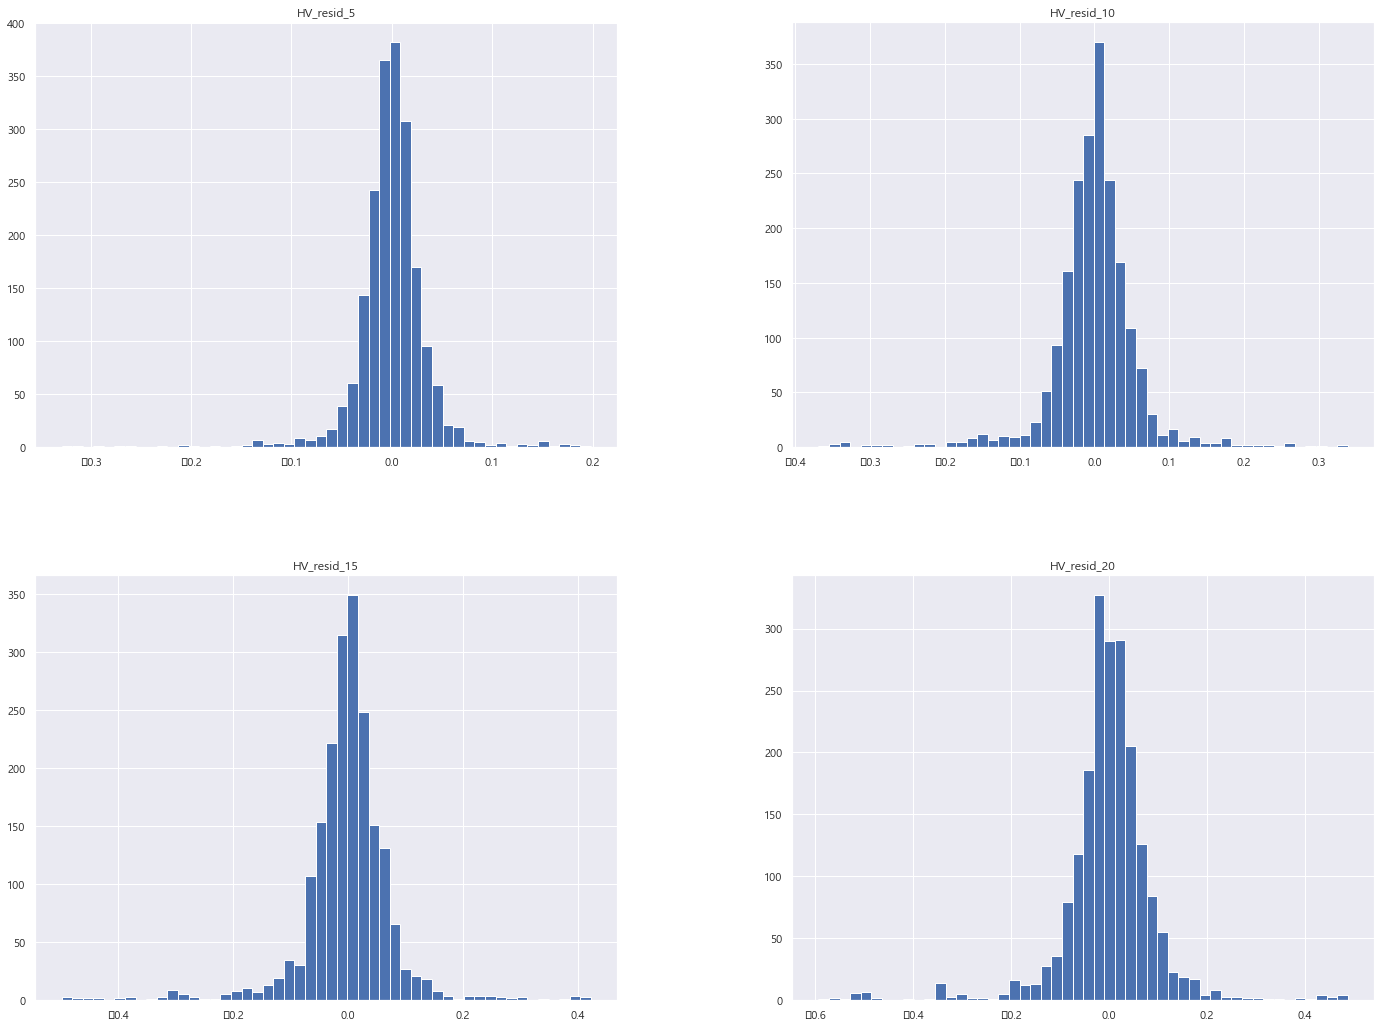

In [30]:
baseline_hv.loc[start_date_train:end_date_train, 'HV_resid_5':'HV_resid_20'].hist(bins=50, figsize=(24, 18))

In [361]:
baseline_hv.loc[start_date_train:end_date_train, 'HV_resid_5':'HV_resid_20']

HV_resid_5  HV_resid_10  HV_resid_15  HV_resid_20
date                                                         
2003-09-29   -0.127249    -0.139703    -0.161700    -0.184196
2003-09-30   -0.081131    -0.094722    -0.115182    -0.137624
2003-10-01   -0.019628    -0.035527    -0.062419    -0.048272
2003-10-02   -0.020592    -0.033539    -0.067349    -0.045089
2003-10-03   -0.011518    -0.031520    -0.054641    -0.022601
...                ...          ...          ...          ...
2011-09-22    0.010774    -0.014365    -0.020938     0.022385
2011-09-23   -0.004545     0.000714    -0.027717     0.016358
2011-09-26   -0.010103    -0.028646    -0.033240     0.009681
2011-09-27   -0.036143    -0.040072    -0.051462    -0.009391
2011-09-28   -0.015123    -0.034928    -0.031223     0.011961

[2016 rows x 4 columns]

In [377]:
resid5 = baseline_hv[['HV_resid_5']]
resid5['class'] = '5'
resid5.columns = ['resid', 'class']
resid5 = resid5[start_date_train:end_date_train]

In [378]:
resid10 = baseline_hv[['HV_resid_10']]
resid10['class'] = '10'
resid10.columns = ['resid', 'class']
resid10 = resid10[start_date_train:end_date_train]

In [379]:
resid15 = baseline_hv[['HV_resid_15']]
resid15['class'] = '15'
resid15.columns = ['resid', 'class']
resid15 = resid15[start_date_train:end_date_train]

In [381]:
resid20 = baseline_hv[['HV_resid_20']]
resid20['class'] = '20'
resid20.columns = ['resid', 'class']
resid20 = resid20[start_date_train:end_date_train]

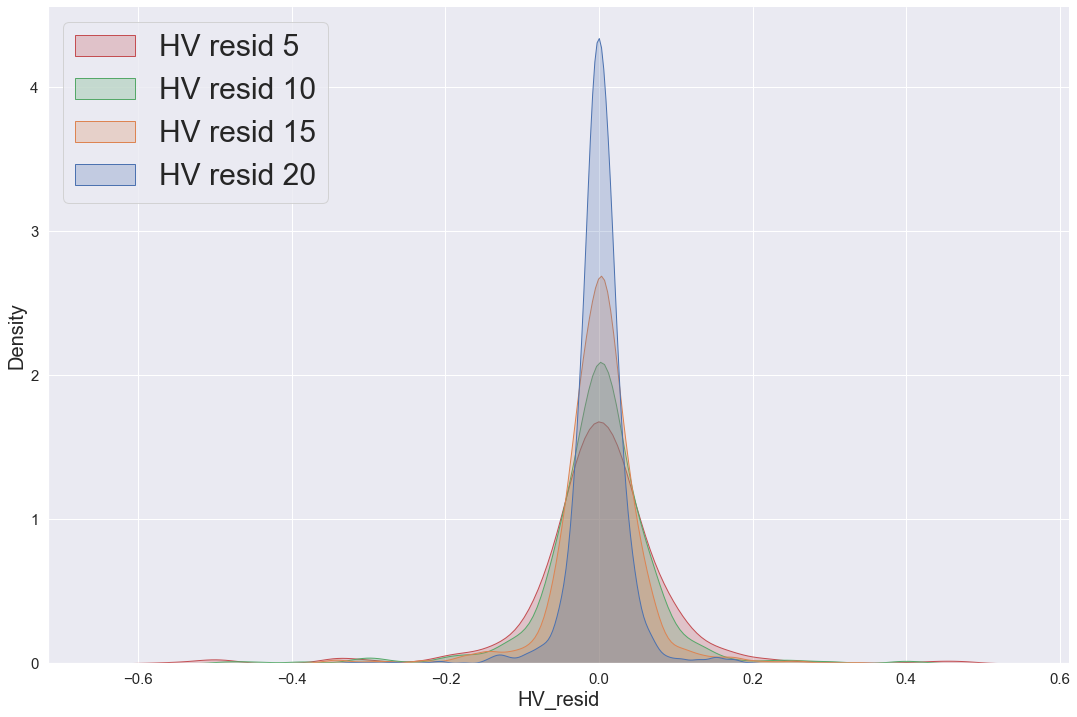

In [402]:
ax = sns.displot(
    data=pd.concat(
    [resid5, resid10, resid15, resid20], axis=0
    ), 
    x='resid', hue='class', kind='kde', height=10, aspect=1.5, fill=True, facet_kws=dict(legend_out=False),
)
plt.xlabel('HV_resid', fontsize=20)     # x축 이름
plt.ylabel('Density', fontsize=20)  # y축 이름
plt.rc(['xtick', 'ytick'], labelsize=15)  # 축 수치 크기
plt.legend(loc='upper left', labels=['HV resid 5', 'HV resid 10', 'HV resid 15', 'HV resid 20'], fontsize=30)
plt.show()

<AxesSubplot:xlabel='date', ylabel='HV'>

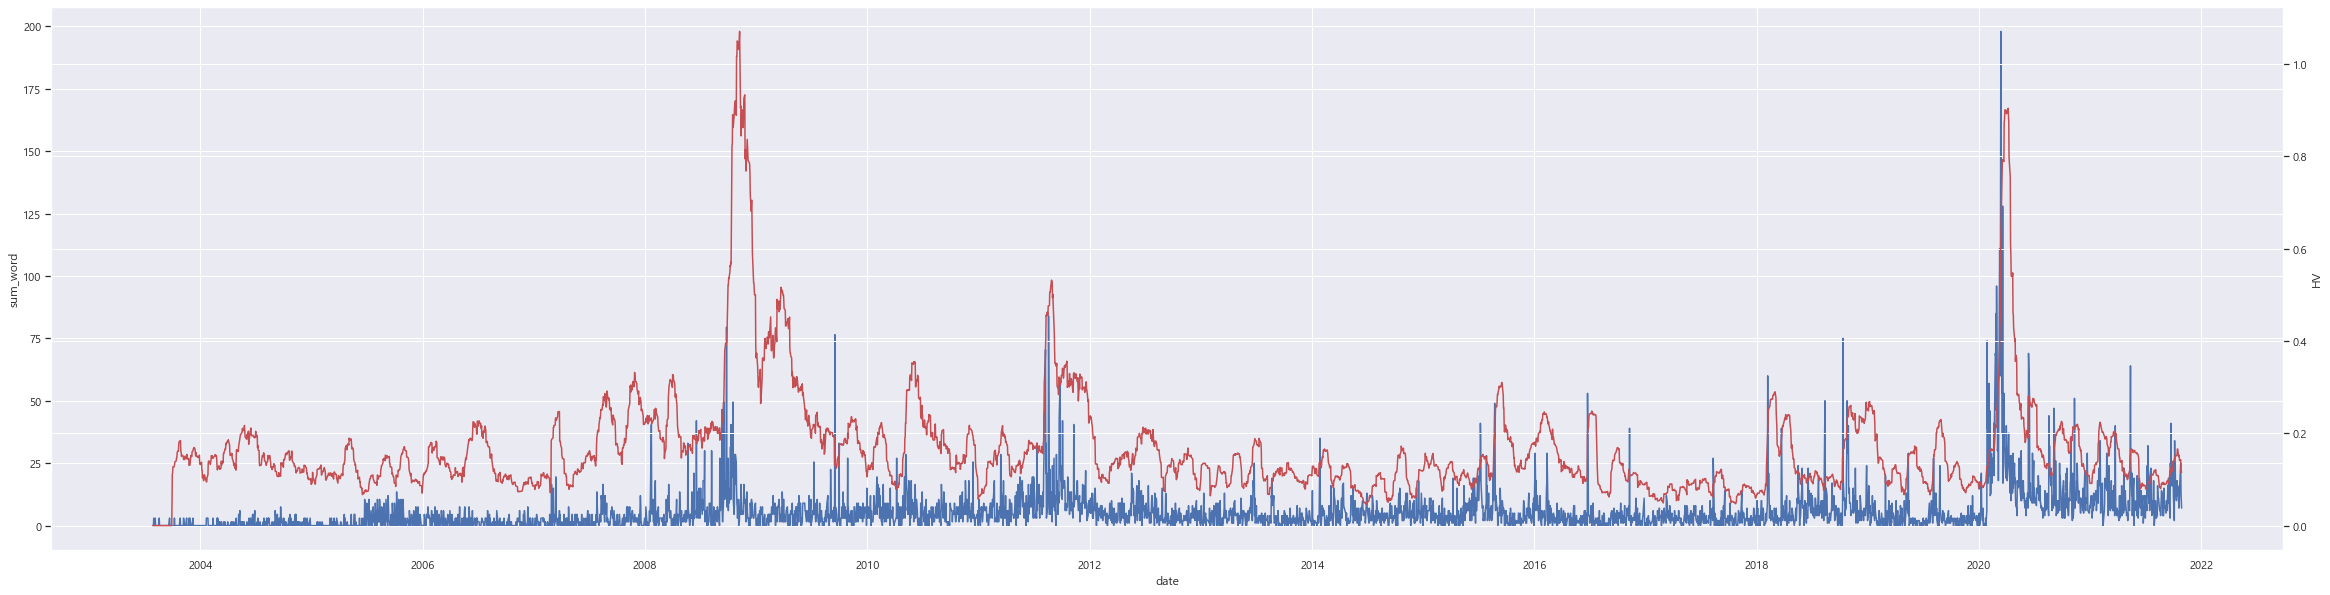

In [31]:
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()

sns.lineplot(ax=ax1, color='b', y=baseline_hv['sum_word'], x=baseline_hv.index)
sns.lineplot(ax=ax2, color='r', y=baseline_hv['HV'], x=baseline_hv.index)

In [32]:
# baseline_hv.to_csv('./baseline_hv.csv')

# 벤치마크 포트폴리오

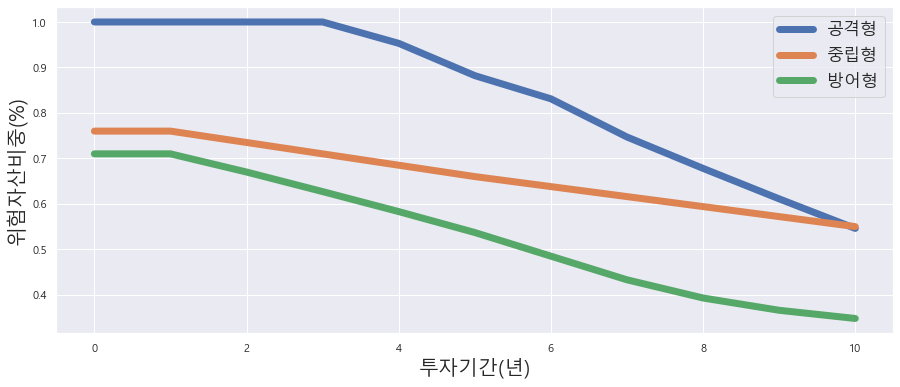

In [33]:
# 10년 벤치마크 글라이드 패스 비중
glide_weight_att = [1.000, 1.000, 1.000, 1.000, .9530, .8820, .8310, .7470, .6780, .6110, .5460]
glide_weight_neu = [.7600, .7600, .7350, .7100, .6850, .6600, .6380, .6160, .5940, .5720, .5500]
glide_weight_def = [.7100, .7100, .6700, .6270, .5830, .5370, .4850, .4330, .3930, .3660, .3480]

# 3년 벤치마크 글라이드 패스 비중
# glide_weight_att = [1.000, 1.000, .8820, .5460]
# glide_weight_neu = [.7600, .7600, .6600, .5500]
# glide_weight_def = [.7100, .7100, .5370, .3480]

f = plt.subplots(figsize=(15, 6))   
sns.lineplot(x=range(len(glide_weight_att)), y=glide_weight_att, lw=7, label='공격형')
sns.lineplot(x=range(len(glide_weight_neu)), y=glide_weight_neu, lw=7, label='중립형')
sns.lineplot(x=range(len(glide_weight_def)), y=glide_weight_def, lw=7, label='방어형')
plt.legend(fontsize=17)                   # 범례 크기
plt.xlabel('투자기간(년)', fontsize=20)     # x축 이름
plt.ylabel('위험자산비중(%)', fontsize=20)  # y축 이름
plt.rc(['xtick', 'ytick'], labelsize=15)  # 축 수치 크기
plt.show()

In [34]:
def makeGlidePath(etf_ohlcv, glide_weight, risk_weight, start_year):
    
    # 날짜, 위험자산 비중 데이터프레임
    df = pd.DataFrame(
        {
            'Date': [str(year) + '-09-29' for year in range(start_year, 2022)], 
            'RA'  : glide_weight
        }
    )
    
    # 장이 열린 날짜로 조정
    df['Date'] = df.apply(lambda x: etf_ohlcv['Adj Close'].index[etf_ohlcv['Adj Close'].index.get_loc(x['Date'], method='nearest')], axis=1)
    
    # 비위험자산 비중
    df['AGG'] = 1 - df['RA']
    
    # 위험자산 비중
    risk_etfs = ['EWG', 'EWH', 'EWJ', 'EWQ', 'EWY', 'QQQ', 'SPY']
    for risk_etf, weight in zip(risk_etfs, risk_weight):
        df[risk_etf] = df['RA'] * weight
    
    df.set_index('Date', inplace=True)
    df.index = pd.to_datetime(['2011-09-29', '2012-09-28', '2013-09-30', '2014-09-29','2015-09-29', '2016-09-29', '2017-09-29', '2018-09-28','2019-09-30', '2020-09-29', '2021-08-28'])
    df.drop('RA', axis=1, inplace=True)
    
    return df

In [35]:
# 벤치마크 글라이드 패스
gp_bench_att = makeGlidePath(etf, glide_weight_att, risk_weight, start_year=int(start_date_bt[:4]))
gp_bench_neu = makeGlidePath(etf, glide_weight_neu, risk_weight, start_year=int(start_date_bt[:4]))
gp_bench_def = makeGlidePath(etf, glide_weight_def, risk_weight, start_year=int(start_date_bt[:4]))

gp_bench_att

AGG       EWG       EWH       EWJ       EWQ      EWY     QQQ  \
2011-09-29  0.000  0.025000  0.025000  0.037500  0.037500  0.25000  0.2000   
2012-09-28  0.000  0.025000  0.025000  0.037500  0.037500  0.25000  0.2000   
2013-09-30  0.000  0.025000  0.025000  0.037500  0.037500  0.25000  0.2000   
2014-09-29  0.000  0.025000  0.025000  0.037500  0.037500  0.25000  0.2000   
2015-09-29  0.047  0.023825  0.023825  0.035737  0.035737  0.23825  0.1906   
2016-09-29  0.118  0.022050  0.022050  0.033075  0.033075  0.22050  0.1764   
2017-09-29  0.169  0.020775  0.020775  0.031162  0.031162  0.20775  0.1662   
2018-09-28  0.253  0.018675  0.018675  0.028012  0.028012  0.18675  0.1494   
2019-09-30  0.322  0.016950  0.016950  0.025425  0.025425  0.16950  0.1356   
2020-09-29  0.389  0.015275  0.015275  0.022912  0.022912  0.15275  0.1222   
2021-08-28  0.454  0.013650  0.013650  0.020475  0.020475  0.13650  0.1092   

                 SPY  
2011-09-29  0.425000  
2012-09-28  0.425000  
2013-09-30  0.425000  
2014-09-29  0.425000  
2015-09-29  0.405025  
2016-09-29  0.374850  
2017-09-29  0.353175  
2018-09-28  0.317475  
2019-09-30  0.288150  
2020-09-29  0.259675  
2021-08-28  0.232050

In [36]:
data = etf['Adj Close'].loc[start_date_pred:end_date_pred]

bench_att = bt.Strategy(
    'bench_att', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bench_att), 
        bt.algos.Rebalance(), 
    ]
)

bench_neu = bt.Strategy(
    'bench_neu', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bench_neu), 
        bt.algos.Rebalance(), 
    ]
)

bench_def = bt.Strategy(
    'bench_def', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bench_def), 
        bt.algos.Rebalance(), 
    ]
)

bench_att_backtest = bt.Backtest(strategy=bench_att, data=data)
bench_neu_backtest = bt.Backtest(strategy=bench_neu, data=data)
bench_def_backtest = bt.Backtest(strategy=bench_def, data=data)

bench_result = bt.run(bench_att_backtest, bench_neu_backtest, bench_def_backtest)
bench_hv = bench_result.prices
bench_hv

bench_att   bench_neu   bench_def
2011-09-28  100.000000  100.000000  100.000000
2011-09-29  100.000000  100.000000  100.000000
2011-09-30   96.894450   97.729401   97.903692
2011-10-03   94.167313   95.755096   96.086552
2011-10-04   96.395743   97.374261   97.578528
...                ...         ...         ...
2021-09-22  332.858715  280.739316  247.178959
2021-09-23  335.484579  282.759517  247.990895
2021-09-24  334.226508  281.729635  247.239736
2021-09-27  333.807647  281.374519  246.918118
2021-09-28  328.225315  276.858313  243.896966

[2517 rows x 3 columns]

In [37]:
for col in bench_hv.columns:
    bench_hv[col + '_HV']          = bench_hv[col].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252)
    bench_hv[col + '_HV_pred_5']   = bench_hv[col + '_HV'].shift(-5)
    bench_hv[col + '_HV_pred_10']  = bench_hv[col + '_HV'].shift(-10)
    bench_hv[col + '_HV_pred_15']  = bench_hv[col + '_HV'].shift(-15)
    bench_hv[col + '_HV_pred_20']  = bench_hv[col + '_HV'].shift(-20)
    bench_hv[col + '_HV_resid_5']  = bench_hv[col + '_HV'].diff(-5)
    bench_hv[col + '_HV_resid_10'] = bench_hv[col + '_HV'].diff(-10)
    bench_hv[col + '_HV_resid_15'] = bench_hv[col + '_HV'].diff(-15)
    bench_hv[col + '_HV_resid_20'] = bench_hv[col + '_HV'].diff(-20)

bench_hv = bench_hv[start_date_bt:end_date_bt]
bench_hv

bench_att   bench_neu   bench_def  bench_att_HV  \
2011-09-29  100.000000  100.000000  100.000000      0.000000   
2011-09-30   96.894450   97.729401   97.903692      0.246495   
2011-10-03   94.167313   95.755096   96.086552      0.222311   
2011-10-04   96.395743   97.374261   97.578528      0.355046   
2011-10-05   98.063501   98.560732   98.664513      0.358458   
...                ...         ...         ...           ...   
2021-08-23  336.107761  283.306716  248.580658      0.061779   
2021-08-24  337.321328  284.252686  249.027577      0.061111   
2021-08-25  337.413535  284.297495  248.903252      0.060327   
2021-08-26  335.691156  282.924752  248.092116      0.062003   
2021-08-27  338.341933  285.081231  249.596845      0.065144   

            bench_att_HV_pred_5  bench_att_HV_pred_10  bench_att_HV_pred_15  \
2011-09-29             0.360796              0.324120              0.305722   
2011-09-30             0.335630              0.316655              0.303504   
2011-10-03             0.372743              0.323141              0.303095   
2011-10-04             0.352095              0.317429              0.307939   
2011-10-05             0.338131              0.313585              0.300349   
...                         ...                   ...                   ...   
2021-08-23             0.065352              0.062779              0.066850   
2021-08-24             0.062112              0.063081              0.061912   
2021-08-25             0.063101              0.064279              0.062211   
2021-08-26             0.062585              0.065887              0.066675   
2021-08-27             0.061158              0.066630              0.080119   

            bench_att_HV_pred_20  bench_att_HV_resid_5  bench_att_HV_resid_10  \
2011-09-29              0.329484             -0.360796              -0.324120   
2011-09-30              0.302691             -0.089134              -0.070160   
2011-10-03              0.305007             -0.150432              -0.100830   
2011-10-04              0.318359              0.002951               0.037617   
2011-10-05              0.318000              0.020328               0.044873   
...                          ...                   ...                    ...   
2021-08-23              0.074235             -0.003572              -0.001000   
2021-08-24              0.077053             -0.001001              -0.001971   
2021-08-25              0.082518             -0.002774              -0.003953   
2021-08-26              0.081647             -0.000582              -0.003884   
2021-08-27              0.076160              0.003987              -0.001486   

            ...  bench_neu_HV_resid_20  bench_def_HV  bench_def_HV_pred_5  \
2011-09-29  ...              -0.243648      0.000000             0.240327   
2011-09-30  ...              -0.043592      0.166389             0.224015   
2011-10-03  ...              -0.065347      0.148701             0.252210   
2011-10-04  ...               0.019176      0.235603             0.238040   
2011-10-05  ...               0.020810      0.237141             0.228639   
...         ...                    ...           ...                  ...   
2021-08-23  ...              -0.011705      0.041410             0.045991   
2021-08-24  ...              -0.015018      0.041283             0.043730   
2021-08-25  ...              -0.020631      0.040595             0.044427   
2021-08-26  ...              -0.018245      0.041777             0.044334   
2021-08-27  ...              -0.009533      0.045832             0.041672   

            bench_def_HV_pred_10  bench_def_HV_pred_15  bench_def_HV_pred_20  \
2011-09-29              0.219153              0.207622              0.225634   
2011-09-30              0.214404              0.206888              0.207246   
2011-10-03              0.218676              0.207005              0.210158   
2011-10-04              0.215161              0.209926              0.219600 

## 전략별 비교

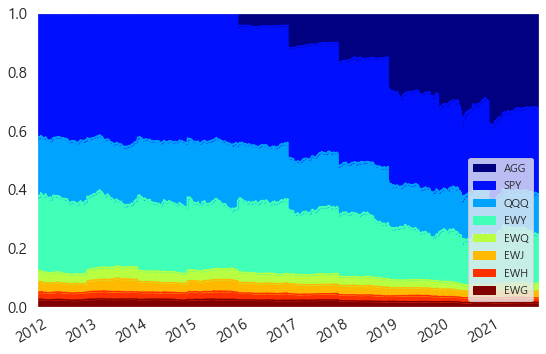

In [38]:
ax = bench_result.get_security_weights(backtest='bench_att').plot.area(
    figsize=(9, 6), legend=False, colormap=cm.jet_r, ylim=[0, 1]
)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles), reversed(labels), loc='lower right')

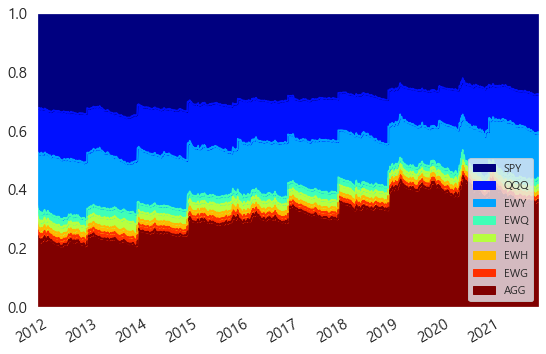

In [39]:
ax = bench_result.get_security_weights(backtest='bench_neu').plot.area(
    figsize=(9, 6), legend=False, colormap=cm.jet_r, ylim=[0, 1]
)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles), reversed(labels), loc='lower right')

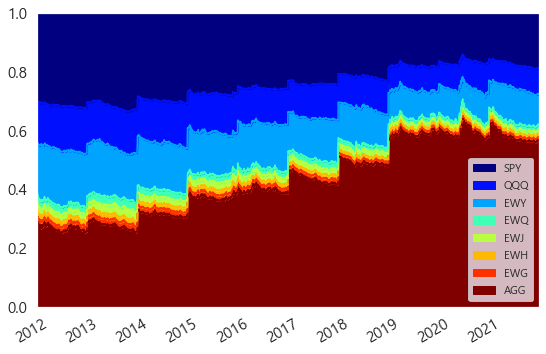

In [40]:
ax = bench_result.get_security_weights(backtest='bench_def').plot.area(
    figsize=(9, 6), legend=False, colormap=cm.jet_r, ylim=[0, 1]
)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles), reversed(labels), loc='lower right')

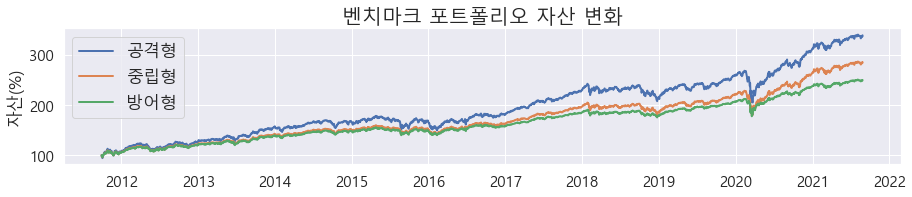

In [41]:
fig, ax = plt.subplots(figsize=(15, 2.5))
sns.lineplot(y='bench_att', label='공격형', lw=2, x=bench_hv.index, data=bench_hv)
sns.lineplot(y='bench_neu', label='중립형', lw=2, x=bench_hv.index, data=bench_hv)
sns.lineplot(y='bench_def', label='방어형', lw=2, x=bench_hv.index, data=bench_hv)

plt.title('벤치마크 포트폴리오 자산 변화', fontsize=20)
plt.legend(fontsize=17, loc='upper left')                   # 범례 크기
# plt.xlabel('연도(년)', fontsize=20)     # x축 이름
plt.ylabel('자산(%)', fontsize=17)  # y축 이름
plt.rc(['xtick', 'ytick'], labelsize=15)  # 축 수치 크기
plt.show()

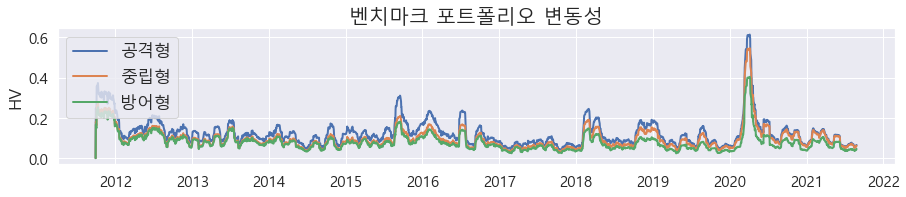

In [42]:
fig, ax = plt.subplots(figsize=(15, 2.5))
sns.lineplot(y='bench_att_HV', label='공격형', lw=2, x=bench_hv.index, data=bench_hv)
sns.lineplot(y='bench_neu_HV', label='중립형', lw=2, x=bench_hv.index, data=bench_hv)
sns.lineplot(y='bench_def_HV', label='방어형', lw=2, x=bench_hv.index, data=bench_hv)

plt.title('벤치마크 포트폴리오 변동성', fontsize=20)
plt.legend(fontsize=17, loc='upper left')                   # 범례 크기
# plt.xlabel('연도(년)', fontsize=20)     # x축 이름
plt.ylabel('HV', fontsize=17)  # y축 이름
plt.rc(['xtick', 'ytick'], labelsize=15)  # 축 수치 크기
plt.show()

# 변동성 예측 기반 포트폴리오

In [43]:
# 예측 글라이드 패스
gp_pred_att = makeGlidePath(etf, glide_weight_att, risk_weight, start_year=int(start_date_bt[:4]))
gp_pred_neu = makeGlidePath(etf, glide_weight_neu, risk_weight, start_year=int(start_date_bt[:4]))
gp_pred_def = makeGlidePath(etf, glide_weight_def, risk_weight, start_year=int(start_date_bt[:4]))

gp_pred_att

AGG       EWG       EWH       EWJ       EWQ      EWY     QQQ  \
2011-09-29  0.000  0.025000  0.025000  0.037500  0.037500  0.25000  0.2000   
2012-09-28  0.000  0.025000  0.025000  0.037500  0.037500  0.25000  0.2000   
2013-09-30  0.000  0.025000  0.025000  0.037500  0.037500  0.25000  0.2000   
2014-09-29  0.000  0.025000  0.025000  0.037500  0.037500  0.25000  0.2000   
2015-09-29  0.047  0.023825  0.023825  0.035737  0.035737  0.23825  0.1906   
2016-09-29  0.118  0.022050  0.022050  0.033075  0.033075  0.22050  0.1764   
2017-09-29  0.169  0.020775  0.020775  0.031162  0.031162  0.20775  0.1662   
2018-09-28  0.253  0.018675  0.018675  0.028012  0.028012  0.18675  0.1494   
2019-09-30  0.322  0.016950  0.016950  0.025425  0.025425  0.16950  0.1356   
2020-09-29  0.389  0.015275  0.015275  0.022912  0.022912  0.15275  0.1222   
2021-08-28  0.454  0.013650  0.013650  0.020475  0.020475  0.13650  0.1092   

                 SPY  
2011-09-29  0.425000  
2012-09-28  0.425000  
2013-09-30  0.425000  
2014-09-29  0.425000  
2015-09-29  0.405025  
2016-09-29  0.374850  
2017-09-29  0.353175  
2018-09-28  0.317475  
2019-09-30  0.288150  
2020-09-29  0.259675  
2021-08-28  0.232050

In [44]:
data = etf['Adj Close'].loc[start_date_pred:end_date_pred]

pred_att = bt.Strategy(
    'pred_att', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_pred_att), 
        bt.algos.Rebalance(), 
    ]
)

pred_neu = bt.Strategy(
    'pred_neu', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_pred_neu), 
        bt.algos.Rebalance(), 
    ]
)

pred_def = bt.Strategy(
    'pred_def', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_pred_def), 
        bt.algos.Rebalance(), 
    ]
)

pred_att_backtest = bt.Backtest(strategy=pred_att, data=data)
pred_neu_backtest = bt.Backtest(strategy=pred_neu, data=data)
pred_def_backtest = bt.Backtest(strategy=pred_def, data=data)

pred_result = bt.run(pred_att_backtest, pred_neu_backtest, pred_def_backtest)
pred_hv = pred_result.prices
pred_hv

pred_att    pred_neu    pred_def
2011-09-28  100.000000  100.000000  100.000000
2011-09-29  100.000000  100.000000  100.000000
2011-09-30   96.894450   97.729401   97.903692
2011-10-03   94.167313   95.755096   96.086552
2011-10-04   96.395743   97.374261   97.578528
...                ...         ...         ...
2021-09-22  332.858715  280.739316  247.178959
2021-09-23  335.484579  282.759517  247.990895
2021-09-24  334.226508  281.729635  247.239736
2021-09-27  333.807647  281.374519  246.918118
2021-09-28  328.225315  276.858313  243.896966

[2517 rows x 3 columns]

In [45]:
pred = pd.read_csv('./pred_df_final.csv', index_col='date')
pred.index = pd.to_datetime(pred.index)
pred

pred
date                
2011-10-27  0.268389
2011-10-28  0.287141
2011-10-31  0.275389
2011-11-01  0.278015
2011-11-02  0.290211
...              ...
2021-09-22  0.123434
2021-09-23  0.120778
2021-09-24  0.126407
2021-09-27  0.124015
2021-09-28  0.119998

[2496 rows x 1 columns]

In [46]:
pred_hv = pd.merge(pred_hv, pred, how='left', left_index=True, right_index=True)
pred_hv

pred_att    pred_neu    pred_def      pred
2011-09-28  100.000000  100.000000  100.000000       NaN
2011-09-29  100.000000  100.000000  100.000000       NaN
2011-09-30   96.894450   97.729401   97.903692       NaN
2011-10-03   94.167313   95.755096   96.086552       NaN
2011-10-04   96.395743   97.374261   97.578528       NaN
...                ...         ...         ...       ...
2021-09-22  332.858715  280.739316  247.178959  0.123434
2021-09-23  335.484579  282.759517  247.990895  0.120778
2021-09-24  334.226508  281.729635  247.239736  0.126407
2021-09-27  333.807647  281.374519  246.918118  0.124015
2021-09-28  328.225315  276.858313  243.896966  0.119998

[2517 rows x 4 columns]

In [47]:
for col in pred_hv.columns:
    pred_hv[col + '_HV']          = pred_hv[col].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252)
    pred_hv[col + '_HV_pred_5']   = pred_hv['pred'].shift(-5)
    pred_hv[col + '_HV_pred_10']  = pred_hv['pred'].shift(-10)
    pred_hv[col + '_HV_pred_15']  = pred_hv['pred'].shift(-15)
    pred_hv[col + '_HV_pred_20']  = pred_hv['pred'].shift(-20)
    pred_hv[col + '_HV_resid_5']  = pred_hv[col + '_HV'] - pred_hv[col + '_HV_pred_5']
    pred_hv[col + '_HV_resid_10'] = pred_hv[col + '_HV'] - pred_hv[col + '_HV_pred_10'] 
    pred_hv[col + '_HV_resid_15'] = pred_hv[col + '_HV'] - pred_hv[col + '_HV_pred_15'] 
    pred_hv[col + '_HV_resid_20'] = pred_hv[col + '_HV'] - pred_hv[col + '_HV_pred_20'] 

pred_hv = pred_hv[start_date_bt:end_date_bt]
pred_hv

pred_att    pred_neu    pred_def      pred  pred_att_HV  \
2011-09-29  100.000000  100.000000  100.000000       NaN     0.000000   
2011-09-30   96.894450   97.729401   97.903692       NaN     0.246495   
2011-10-03   94.167313   95.755096   96.086552       NaN     0.222311   
2011-10-04   96.395743   97.374261   97.578528       NaN     0.355046   
2011-10-05   98.063501   98.560732   98.664513       NaN     0.358458   
...                ...         ...         ...       ...          ...   
2021-08-23  336.107761  283.306716  248.580658  0.078823     0.061779   
2021-08-24  337.321328  284.252686  249.027577  0.087170     0.061111   
2021-08-25  337.413535  284.297495  248.903252  0.088121     0.060327   
2021-08-26  335.691156  282.924752  248.092116  0.088606     0.062003   
2021-08-27  338.341933  285.081231  249.596845  0.090379     0.065144   

            pred_att_HV_pred_5  pred_att_HV_pred_10  pred_att_HV_pred_15  \
2011-09-29                 NaN                  NaN                  NaN   
2011-09-30                 NaN                  NaN                  NaN   
2011-10-03                 NaN                  NaN                  NaN   
2011-10-04                 NaN                  NaN                  NaN   
2011-10-05                 NaN                  NaN                  NaN   
...                        ...                  ...                  ...   
2021-08-23            0.091057             0.089805             0.097440   
2021-08-24            0.091017             0.090279             0.096687   
2021-08-25            0.090356             0.092548             0.094851   
2021-08-26            0.090799             0.095142             0.092202   
2021-08-27            0.090013             0.094815             0.096496   

            pred_att_HV_pred_20  pred_att_HV_resid_5  ...  \
2011-09-29             0.268389                  NaN  ...   
2011-09-30             0.287141                  NaN  ...   
2011-10-03             0.275389                  NaN  ...   
2011-10-04             0.278015                  NaN  ...   
2011-10-05             0.290211                  NaN  ...   
...                         ...                  ...  ...   
2021-08-23             0.115225            -0.029278  ...   
2021-08-24             0.123434            -0.029907  ...   
2021-08-25             0.120778            -0.030029  ...   
2021-08-26             0.126407            -0.028796  ...   
2021-08-27             0.124015            -0.024868  ...   

            pred_def_HV_resid_20   pred_HV  pred_HV_pred_5  pred_HV_pred_10  \
2011-09-29             -0.268389       NaN             NaN              NaN   
2011-09-30             -0.120752       NaN             NaN              NaN   
2011-10-03             -0.126687       NaN             NaN              NaN   
2011-10-04             -0.042412       NaN             NaN              NaN   
2011-10-05             -0.053070       NaN             NaN              NaN   
...                          ...       ...             ...              ...   
2021-08-23             -0.073815  0.546818        0.091057         0.089805   
2021-08-24             -0.082151  0.688093        0.091017         0.090279   
2021-08-25             -0.080184  0.681463        0.090356         0.092548   
2021-08-26             -0.084630  0.669415        0.090799         0.095142   
2021-08-27             -0.078184  0.678076        0.090013         0.094815   

            pred_HV_pred_15  pred_HV_pred_20  pred_HV_resid_5  \
2011-09-29              NaN         0.268389              NaN   
2011-09-30              NaN         0.287141              NaN   
2011-10-03              NaN         0.275389              NaN   
2011-10-04              NaN         0.278015              NaN   
2011-10-05              NaN         0.290211              NaN   
...                     ...              ...              ...   
2021-08-23         0.097440         0.115225         0.455761   
2021-08-24         0.0

# 리밸런싱 함수

In [48]:
def getOutSignal(a, b):
    if a <= b:
        result_sig = 1
    else:
        result_sig = 0
    return result_sig

def getOutDate(a, b):
    if (a == 1) & (b ==0):
        result_out = 1
    else:
        result_out = 0
    return result_out

def getFillDate(a, b):
    if (a == 1) & (b == 0):
        result_fill = 'out'
    elif (a == 0) & (b == 1):
        result_fill = 'in'
    else:
        result_fill = np.nan
    return result_fill

def getRebalancedGlidePath(
    portfolio_hv, glide_path, 
    resid_diff, out_multiple, in_multiple, rebalance_weight, 
    hv_resid_mean, hv_resid_std, 
):
    
    df = portfolio_hv.copy()
    df.columns = ['portfolio', 'HV', 'HV_resid_5', 'HV_resid_10', 'HV_resid_15', 'HV_resid_20']
    
    if resid_diff == 5:
        df = df[['portfolio', 'HV', 'HV_resid_5']]
        hv_resid_mean = hv_resid_mean[0]
        hv_resid_std  = hv_resid_std[0]
    elif resid_diff == 10:
        df = df[['portfolio', 'HV', 'HV_resid_10']]
        hv_resid_mean = hv_resid_mean[1]
        hv_resid_std  = hv_resid_std[1]
    elif resid_diff == 15:
        df = df[['portfolio', 'HV', 'HV_resid_15']]
        hv_resid_mean = hv_resid_mean[2]
        hv_resid_std  = hv_resid_std[2]
    elif resid_diff == 20:
        df = df[['portfolio', 'HV', 'HV_resid_20']]
        hv_resid_mean = hv_resid_mean[3]
        hv_resid_std  = hv_resid_std[3]
    else:
        print('invalid resid diff')
    df.columns = ['portfolio', 'HV', 'HV_resid']
    
    gp = glide_path.copy()
    
    # 기존 글라이드 패스와 리밸런싱 일자를 구분하기 위한 컬럼
    gp['class'] = 'gp'
    
    # 리밸런싱 시그널
    df['HV_resid_signal'] = hv_resid_mean - out_multiple * hv_resid_std
    df['Out_signal'] = df.apply(lambda x: getOutSignal(x['HV_resid'], x['HV_resid_signal']), axis=1)
    df['Out_signal_shift'] = df['Out_signal'].shift(1)
    
    # 위험자산의 비중을 낮추는 일자
    df['Out_date'] = df.apply(lambda x: getOutDate(x['Out_signal'], x['Out_signal_shift']), axis=1)
    
    # 위험자산의 비중을 이전의 글라이드 패스로 복구할 일자
    df.reset_index(inplace=True)
    out_idx = df[df['Out_date'] == 1].index
    rb_idx  = []
    in_idx  = []
    for out_date_idx in out_idx:
        idx = out_date_idx
        try:
            while df.iloc[idx, 3] <= (hv_resid_mean + in_multiple * hv_resid_std):
                rb_idx.append(idx)
                idx = idx + 1
            in_idx.append(idx)
        except:
            pass
    df['In_date'] = 0
    df.iloc[in_idx, -1] = 1
    
    df['Rebalance'] = 0
    df.iloc[rb_idx, -1] = 1
    
    df['Rebalance_shift'] = df['Rebalance'].shift(1)
    df['Fill_date'] = df.apply(lambda x: getFillDate(x['Rebalance'], x['Rebalance_shift']), axis=1)
    
    df.set_index('index', inplace=True)
    df['class'] = np.nan
    df.iloc[out_idx, -1] = 'out'
    df.iloc[in_idx,  -1] = 'in'
    
    history = df.copy()
    
    
    # 기존 글라이드 패스에 리밸런싱 일자 추가
    gp = pd.concat([gp, df[df['class'].notna()][['class']]], axis=0).sort_index()
    gp.reset_index(inplace=True)
    i = 0
    drop_cnt = 0
    while i < gp.shape[0] + drop_cnt:
        if gp.loc[i, 'class'] == 'out':
            gp.loc[i, 'EWG'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWG']
            gp.loc[i, 'EWH'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWH']
            gp.loc[i, 'EWJ'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWJ']
            gp.loc[i, 'EWQ'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWQ']
            gp.loc[i, 'EWY'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWY']
            gp.loc[i, 'QQQ'] = (1 - rebalance_weight) * gp.loc[i - 1, 'QQQ']
            gp.loc[i, 'SPY'] = (1 - rebalance_weight) * gp.loc[i - 1, 'SPY']
            gp.loc[i, 'AGG'] = 1 - gp.loc[i, 'EWG':'SPY'].sum()
        elif gp.loc[i, 'class'] == 'in':
            if gp.loc[i - 1, 'class'] == 'gp':
                gp.loc[i, 'EWG'] = gp.loc[i - 1, 'EWG']
                gp.loc[i, 'EWH'] = gp.loc[i - 1, 'EWH']
                gp.loc[i, 'EWJ'] = gp.loc[i - 1, 'EWJ']
                gp.loc[i, 'EWQ'] = gp.loc[i - 1, 'EWQ']
                gp.loc[i, 'EWY'] = gp.loc[i - 1, 'EWY']
                gp.loc[i, 'QQQ'] = gp.loc[i - 1, 'QQQ']
                gp.loc[i, 'SPY'] = gp.loc[i - 1, 'SPY']
                gp.loc[i, 'AGG'] = gp.loc[i - 1, 'AGG']
                gp.drop(axis=0, index=[i - 1], inplace=True)
                drop_cnt = drop_cnt + 1
            elif gp.loc[i - 1, 'class'] == 'out':
                gp.loc[i, 'EWG'] = gp.loc[i - 2, 'EWG']
                gp.loc[i, 'EWH'] = gp.loc[i - 2, 'EWH']
                gp.loc[i, 'EWJ'] = gp.loc[i - 2, 'EWJ']
                gp.loc[i, 'EWQ'] = gp.loc[i - 2, 'EWQ']
                gp.loc[i, 'EWY'] = gp.loc[i - 2, 'EWY']
                gp.loc[i, 'QQQ'] = gp.loc[i - 2, 'QQQ']
                gp.loc[i, 'SPY'] = gp.loc[i - 2, 'SPY']
                gp.loc[i, 'AGG'] = gp.loc[i - 2, 'AGG']
        elif gp.loc[i, 'class'] == 'gp':
            pass
        i = i + 1
    gp.set_index('index', inplace=True)
    
    
    return gp, history

# 리밸런싱 백테스트

In [214]:
# 고객에게 제안 가능한 조건
resid_diff = 20
out_multiple = 0.8
in_multiple  = 0
rebalance_weight = 0.9

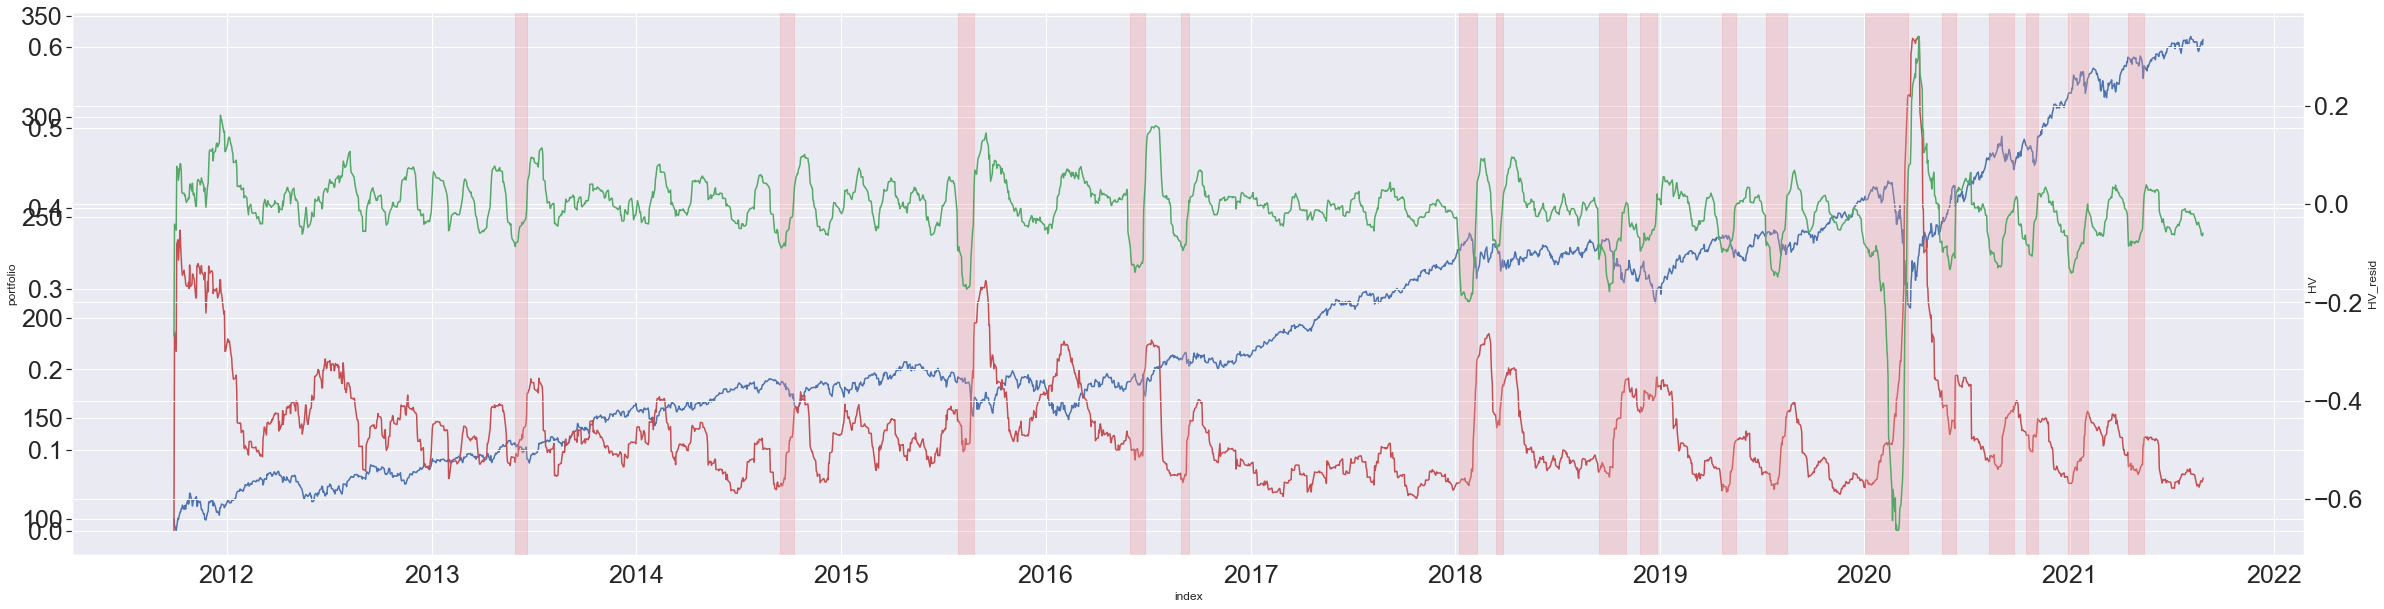

In [418]:
# 공격형 글라이드 패스 리밸런싱
gp_bt_att, history_bt_att = getRebalancedGlidePath(
    pred_hv[['pred_att', 'pred_att_HV', 'pred_att_HV_resid_5', 'pred_att_HV_resid_10', 'pred_att_HV_resid_15', 'pred_att_HV_resid_20']], 
    gp_pred_att, 
    resid_diff=resid_diff, out_multiple=out_multiple, 
    in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
    hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
)
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
sns.lineplot(ax=ax1, color='b', y=history_bt_att['portfolio'], x=history_bt_att.index)
sns.lineplot(ax=ax2, color='r', y=history_bt_att['HV'], x=history_bt_att.index)
sns.lineplot(ax=ax3, color='g', y=history_bt_att['HV_resid'], x=history_bt_att.index)

out_idx_att = history_bt_att[history_bt_att['Fill_date'] == 'out'].index
in_idx_att  = history_bt_att[history_bt_att['Fill_date'] == 'in'].index
for i, j in zip(out_idx_att, in_idx_att):
    ax3.axvspan(i, j, color='#EF9A9A', alpha=0.3)

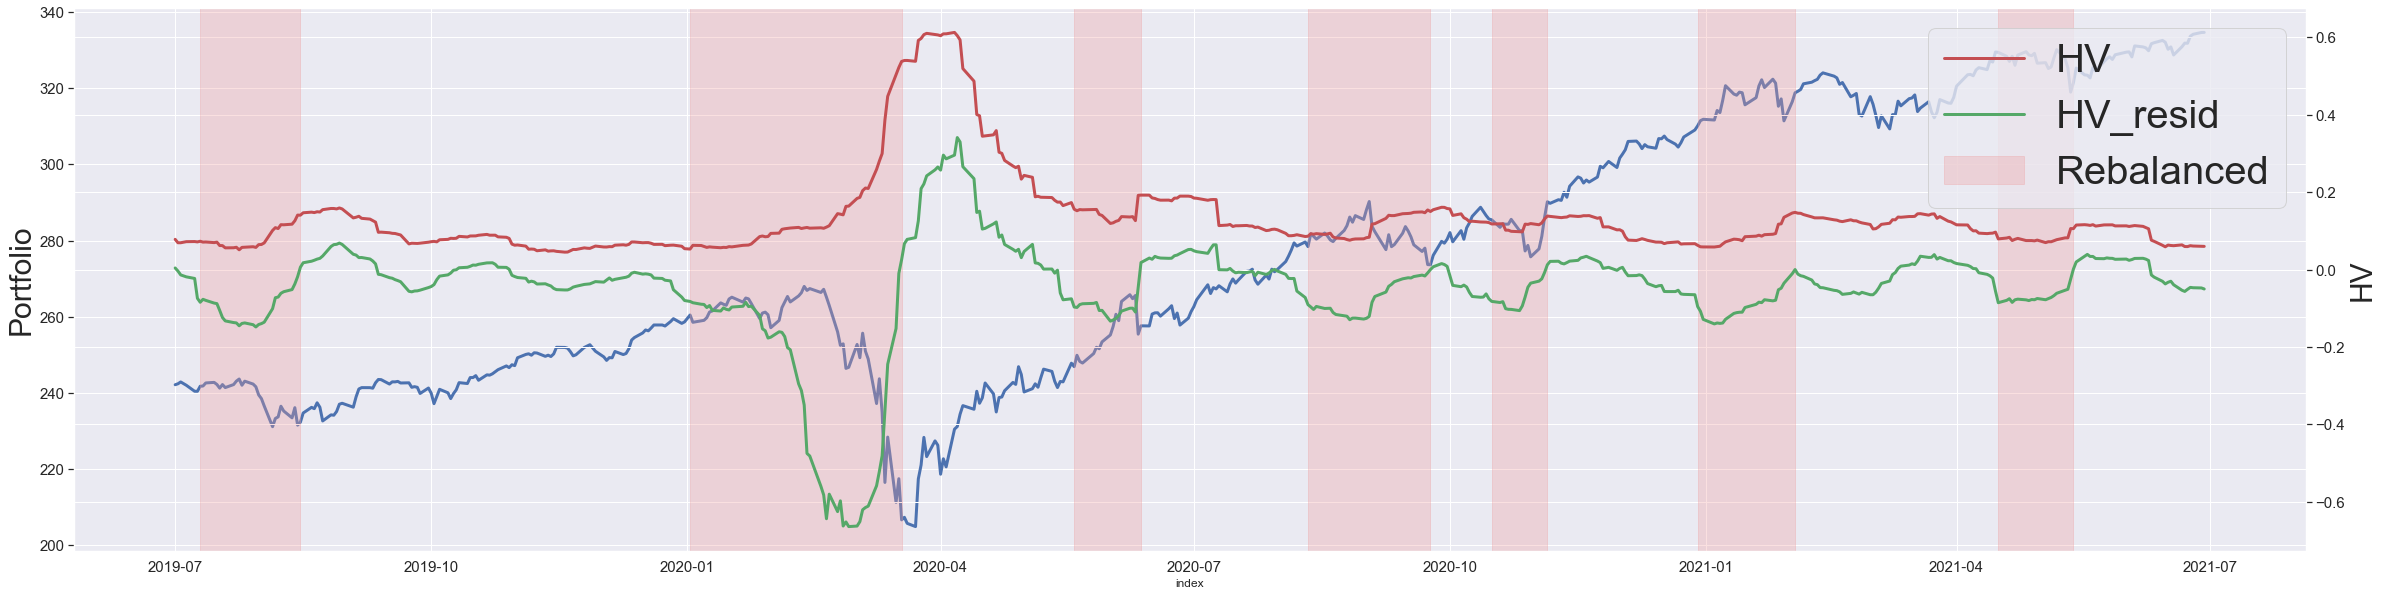

In [408]:
# # 공격형 글라이드 패스 리밸런싱 : 특정 구간
# gp_bt_att, history_bt_att = getRebalancedGlidePath(
#     pred_hv[['pred_att', 'pred_att_HV', 'pred_att_HV_resid_5', 'pred_att_HV_resid_10', 'pred_att_HV_resid_15', 'pred_att_HV_resid_20']], 
#     gp_pred_att, 
#     resid_diff=resid_diff, out_multiple=out_multiple, 
#     in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
#     hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
# )
# history_bt_att = history_bt_att['2019-06-30':'2021-06-29']

# fig, ax1 = plt.subplots(figsize=(40, 10))
# ax2 = ax1.twinx()
# sns.lineplot(ax=ax1, color='b', lw=3, y=history_bt_att['portfolio'], x=history_bt_att.index)
# sns.lineplot(ax=ax2, color='r', lw=3, y=history_bt_att['HV'], x=history_bt_att.index)
# sns.lineplot(ax=ax2, color='g', lw=3, y=history_bt_att['HV_resid'], x=history_bt_att.index)

# out_idx_att = history_bt_att[history_bt_att['Fill_date'] == 'out'].index
# in_idx_att  = history_bt_att[history_bt_att['Fill_date'] == 'in'].index
# for i, j in zip(out_idx_att, in_idx_att):
#     ax2.axvspan(i, j, color='#EF9A9A', alpha=0.3)

# plt.rc(['xtick', 'ytick'], labelsize=20)
# plt.legend(fontsize=(40), labels=['HV', 'HV_resid', 'Rebalanced'])

# ax1.set_ylabel('Portfolio', fontsize=30)
# ax2.set_ylabel('HV', fontsize=30)
# plt.rc(['xtick', 'ytick'], labelsize=25)
# plt.show()

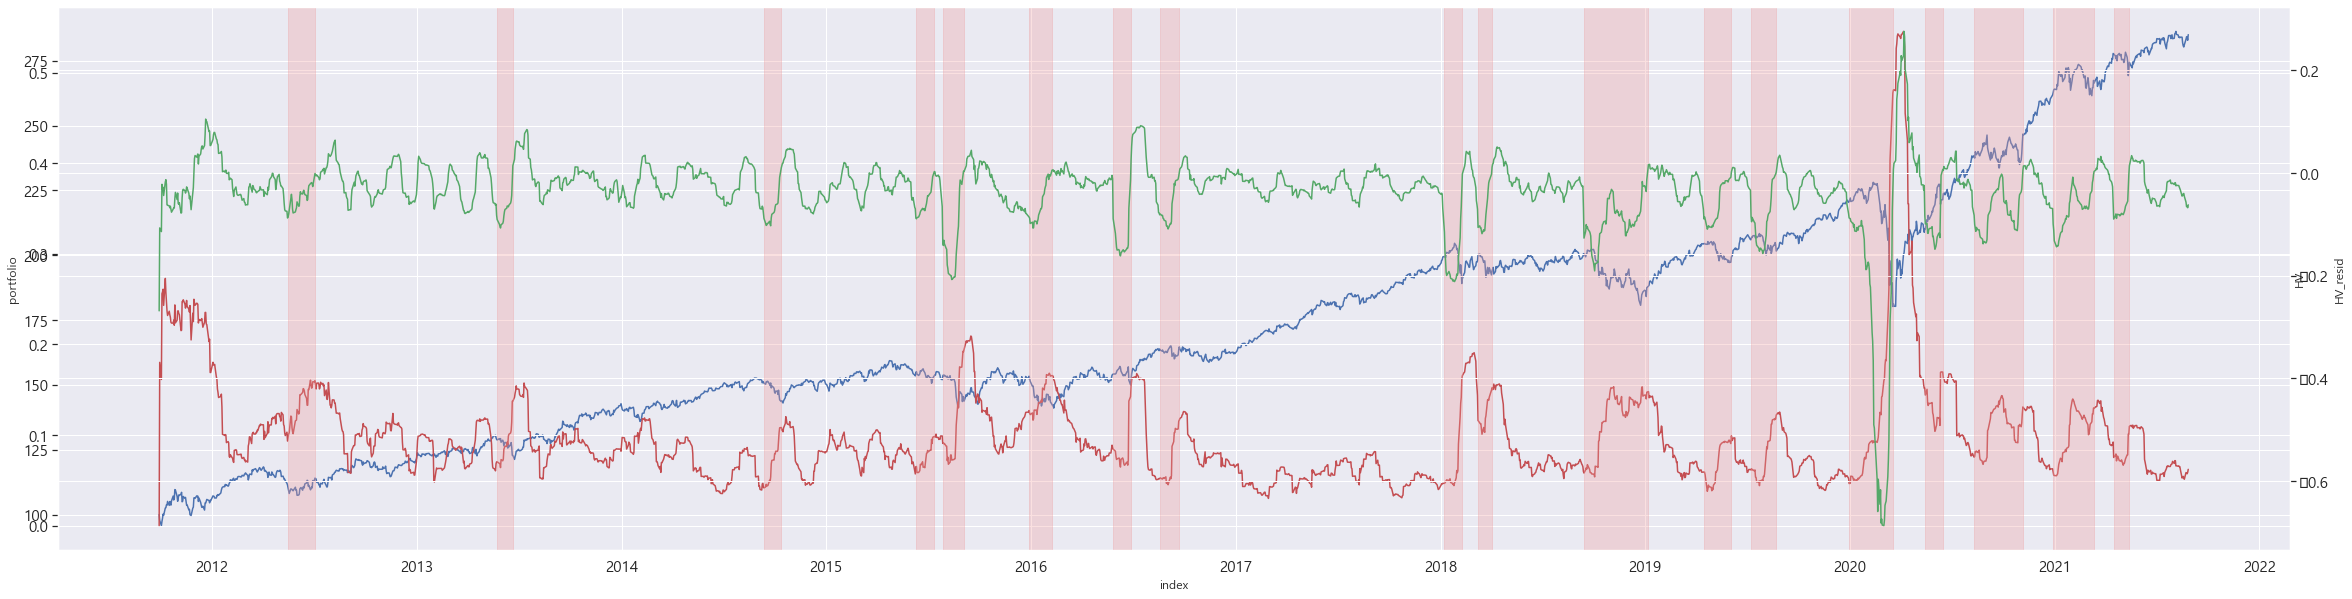

In [216]:
# 중립형 글라이드 패스 리밸런싱
gp_bt_neu, history_bt_neu = getRebalancedGlidePath(
    pred_hv[['pred_neu', 'pred_neu_HV', 'pred_neu_HV_resid_5', 'pred_neu_HV_resid_10', 'pred_neu_HV_resid_15', 'pred_neu_HV_resid_20']], 
    gp_pred_neu, 
    resid_diff=resid_diff, out_multiple=out_multiple, 
    in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
    hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
)
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
sns.lineplot(ax=ax1, color='b', y=history_bt_neu['portfolio'], x=history_bt_neu.index)
sns.lineplot(ax=ax2, color='r', y=history_bt_neu['HV'], x=history_bt_neu.index)
sns.lineplot(ax=ax3, color='g', y=history_bt_neu['HV_resid'], x=history_bt_neu.index)

out_idx_neu = history_bt_neu[history_bt_neu['Fill_date'] == 'out'].index
in_idx_neu  = history_bt_neu[history_bt_neu['Fill_date'] == 'in'].index
for i, j in zip(out_idx_neu, in_idx_neu):
    ax3.axvspan(i, j, color='#EF9A9A', alpha=0.3)

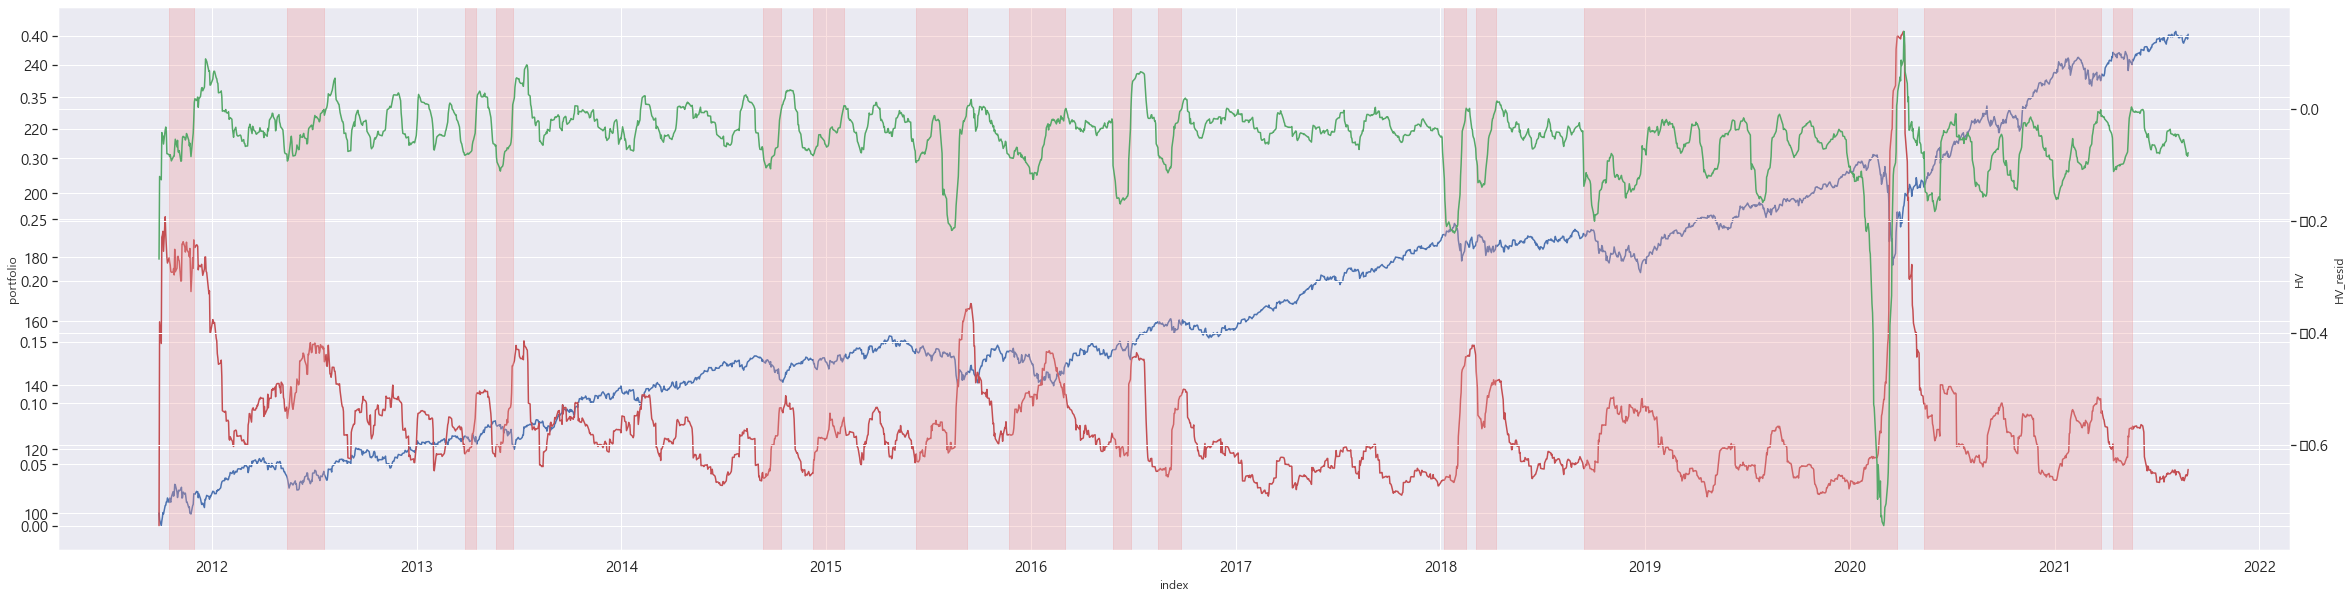

In [217]:
# 방어형 글라이드 패스 리밸런싱
gp_bt_def, history_bt_def = getRebalancedGlidePath(
    pred_hv[['pred_def', 'pred_def_HV', 'pred_def_HV_resid_5', 'pred_def_HV_resid_10', 'pred_def_HV_resid_15', 'pred_def_HV_resid_20']], 
    gp_bench_def, 
    resid_diff=resid_diff, out_multiple=out_multiple, 
    in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
    hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
)
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
sns.lineplot(ax=ax1, color='b', y=history_bt_def['portfolio'], x=history_bt_def.index)
sns.lineplot(ax=ax2, color='r', y=history_bt_def['HV'], x=history_bt_def.index)
sns.lineplot(ax=ax3, color='g', y=history_bt_def['HV_resid'], x=history_bt_def.index)

out_idx_def = history_bt_def[history_bt_def['Fill_date'] == 'out'].index
in_idx_def  = history_bt_def[history_bt_def['Fill_date'] == 'in'].index
for i, j in zip(out_idx_def, in_idx_def):
    ax3.axvspan(i, j, color='#EF9A9A', alpha=0.3)

In [218]:
# 전략별 리밸런싱 횟수
print('공격형 : ', len(out_idx_att))
print('중립형 : ', len(out_idx_neu))
print('방어형 : ', len(out_idx_def))

공격형 :  17
중립형 :  18
방어형 :  16


In [219]:
data = etf['Adj Close'].loc[start_date_bt:end_date_bt]

bt_att = bt.Strategy(
    'bt_att', 
    algos=[
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bt_att.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)

bt_neu = bt.Strategy(
    'bt_neu', 
    algos=[
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bt_neu.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)

bt_def = bt.Strategy(
    'bt_def', 
    algos=[
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bt_def.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)

bt_att_backtest = bt.Backtest(strategy=bt_att, data=data)
bt_neu_backtest = bt.Backtest(strategy=bt_neu, data=data)
bt_def_backtest = bt.Backtest(strategy=bt_def, data=data)

bt_result = bt.run(bt_att_backtest, bt_neu_backtest, bt_def_backtest)
bt_hv = bt_result.prices
bt_hv

bt_att      bt_neu      bt_def
2011-09-28  100.000000  100.000000  100.000000
2011-09-29  100.000000  100.000000  100.000000
2011-09-30   96.894450   97.729401   97.903692
2011-10-03   94.167313   95.755096   96.086552
2011-10-04   96.395743   97.374261   97.578528
...                ...         ...         ...
2021-08-23  597.563185  380.585000  259.301201
2021-08-24  596.958858  380.029398  258.928421
2021-08-25  595.947922  379.309251  258.437495
2021-08-26  595.714801  379.340594  258.459600
2021-08-27  597.641935  380.390346  259.173883

[2496 rows x 3 columns]

# 모든 경우의 수

In [84]:
data = etf['Adj Close'].loc[start_date_bt:end_date_bt]

rb_bt_results = []
rows = []

for resid_diff in [10, 15, 20]:
    for out_multiple in [0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9]:
        for rebalance_weight in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            
            att_row = []
            neu_row = []
            def_row = []
            
            gp_att, history_att = getRebalancedGlidePath(
                pred_hv[['pred_att', 'pred_att_HV', 'pred_att_HV_resid_5', 'pred_att_HV_resid_10', 'pred_att_HV_resid_15', 'pred_att_HV_resid_20']], 
                gp_pred_att, 
                resid_diff=resid_diff, out_multiple=out_multiple, 
                in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
                hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
            )
            gp_neu, history_neu = getRebalancedGlidePath(
                pred_hv[['pred_neu', 'pred_neu_HV', 'pred_neu_HV_resid_5', 'pred_neu_HV_resid_10', 'pred_neu_HV_resid_15', 'pred_neu_HV_resid_20']], 
                gp_pred_neu, 
                resid_diff=resid_diff, out_multiple=out_multiple, 
                in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
                hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
            )
            gp_def, history_def = getRebalancedGlidePath(
                pred_hv[['pred_def', 'pred_def_HV', 'pred_def_HV_resid_5', 'pred_def_HV_resid_10', 'pred_def_HV_resid_15', 'pred_def_HV_resid_20']], 
                gp_pred_def, 
                resid_diff=resid_diff, out_multiple=out_multiple, 
                in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
                hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
            )
            
            att = bt.Strategy(
                'att', 
                algos=[
                    bt.algos.
                    bt.algos.SelectAll(), 
                    bt.algos.WeighTarget(gp_att.drop('class', axis=1)), 
                    bt.algos.Rebalance(), 
                ]
            )
            neu = bt.Strategy(
                'neu', 
                algos=[
                    bt.algos.
                    bt.algos.SelectAll(), 
                    bt.algos.WeighTarget(gp_neu.drop('class', axis=1)), 
                    bt.algos.Rebalance(), 
                ]
            )
            deff = bt.Strategy(
                'deff', 
                algos=[
                    bt.algos.
                    bt.algos.SelectAll(), 
                    bt.algos.WeighTarget(gp_def.drop('class', axis=1)), 
                    bt.algos.Rebalance(), 
                ]
            )
            
            att_backtest = bt.Backtest(strategy=att, data=data)
            neu_backtest = bt.Backtest(strategy=neu, data=data)
            def_backtest = bt.Backtest(strategy=deff, data=data)
            rb_bt_result = bt.run(att_backtest, neu_backtest, def_backtest)
            rb_bt_results.append(rb_bt_result)
            rb_bt_hv = rb_bt_result.prices
            
            att_row.append('att')
            att_row.append(rb_bt_hv.iloc[-1, 0])
            att_row.append(gp_att[gp_att['class'] == 'out'].shape[0])
            att_row.append(resid_diff)
            att_row.append(out_multiple)
            att_row.append(rebalance_weight)
            rows.append(att_row)
            
            neu_row.append('neu')
            neu_row.append(rb_bt_hv.iloc[-1, 1])
            neu_row.append(gp_neu[gp_neu['class'] == 'out'].shape[0])
            neu_row.append(resid_diff)
            neu_row.append(out_multiple)
            neu_row.append(rebalance_weight)
            rows.append(neu_row)
            
            def_row.append('deff')
            def_row.append(rb_bt_hv.iloc[-1, 2])
            def_row.append(gp_def[gp_def['class'] == 'out'].shape[0])
            def_row.append(resid_diff)
            def_row.append(out_multiple)
            def_row.append(rebalance_weight)
            rows.append(def_row)

rb_bt_stats = pd.DataFrame(rows, columns=['class', 'return', 'rb_count', 'resid_diff', 'out_multiple', 'rebalance_weight'])
rb_bt_stats

class      return  rb_count  resid_diff  out_multiple  rebalance_weight
0     att  335.162381        91          10           0.2               0.1
1     neu  264.986306        89          10           0.2               0.1
2    deff  239.121542        53          10           0.2               0.1
3     att  328.061044        91          10           0.2               0.2
4     neu  248.547235        89          10           0.2               0.2
5    deff  224.776064        53          10           0.2               0.2
6     att  318.947777        91          10           0.2               0.3
7     neu  234.199686        89          10           0.2               0.3
8    deff  212.803047        53          10           0.2               0.3
9     att  309.170929        91          10           0.2               0.4
10    neu  221.701845        89          10           0.2               0.4
11   deff  202.627977        53          10           0.2               0.4
12    att  299.465936        91          10           0.2               0.5
13    neu  210.824378        89          10           0.2               0.5
14   deff  193.812234        53          10           0.2               0.5
15    att  290.041954        91          10           0.2               0.6
16    neu  201.370695        89          10           0.2               0.6
17   deff  186.036180        53          10           0.2               0.6
18    att  281.030470        91          10           0.2               0.7
19    neu  193.222388        89          10           0.2               0.7
20   deff  179.062824        53          10           0.2               0.7
21    att  272.314878        91          10           0.2               0.8
22    neu  186.286080        89          10           0.2               0.8
23   deff  172.723911        53          10           0.2               0.8
24    att  263.779641        91          10           0.2               0.9
25    neu  180.444650        89          10           0.2               0.9
26   deff  166.887893        53          10           0.2               0.9
27    att  333.424543        86          10           0.3               0.1
28    neu  249.773699       107          10           0.3               0.1
29   deff  230.715238        64          10           0.3               0.1
30    att  319.524638        86          10           0.3               0.2
31    neu  226.034708       107          10           0.3               0.2
32   deff  214.692860        64          10           0.3               0.2
33    att  301.809303        86          10           0.3               0.3
34    neu  209.420444       107          10           0.3               0.3
35   deff  203.383701        64          10           0.3               0.3
36    att  283.695763        86          10           0.3               0.4
37    neu  197.616087       107          10           0.3               0.4
38   deff  194.868135        64          10           0.3               0.4
39    att  266.891464        86          10           0.3               0.5
40    neu  189.088062       107          10           0.3               0.5
41   deff  188.032109        64          10           0.3               0.5
42    att  252.045738        86          10           0.3               0.6
43    neu  182.825847       107          10           0.3               0.6
44   deff  182.212662        64          10           0.3               0.6
45    att  239.320930        86          10           0.3               0.7
46    neu  178.093079       107          10           0.3               0.7
47   deff  176.997609        64          10           0.3               0.7
48    att  228.569289        86          10           0.3               0.8
49    neu  174.387787       107          10           0.3               0.8
50   deff  172.214400        64          10           0.3               0.8
51    att  219.416491        86          10         

In [309]:
# rb_bt_stats.to_csv('./rb_scatter.csv', index=False)

In [196]:
len(rb_bt_results)

189

In [190]:
rb_bt_stats[(rb_bt_stats['resid_diff'] == 20) & (rb_bt_stats['out_multiple'] == 0.8) & (rb_bt_stats['rebalance_weight'] == 0.9)]

class      return  rb_count  resid_diff  out_multiple  rebalance_weight
537   att  597.641935        20          20           0.8               0.9
538   neu  380.390346        25          20           0.8               0.9
539  deff  259.173883        34          20           0.8               0.9

In [92]:
rb_bt_stats.describe()

return    rb_count  resid_diff  out_multiple  rebalance_weight
count  567.000000  567.000000  567.000000    567.000000        567.000000
mean   278.638156   60.333333   15.000000      0.528571          0.500000
std     84.554802   24.276019    4.086088      0.237542          0.258427
min    154.961912   19.000000   10.000000      0.200000          0.100000
25%    212.229579   40.000000   10.000000      0.300000          0.300000
50%    256.011979   62.000000   15.000000      0.500000          0.500000
75%    345.950845   77.000000   20.000000      0.800000          0.700000
max    597.641935  112.000000   20.000000      0.900000          0.900000

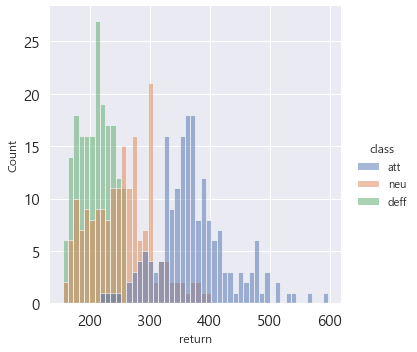

In [113]:
sns.displot(data=rb_bt_stats, x='return', hue='class', bins=50)

In [107]:
rb_bt_stats.groupby('class').mean().sort_values('return', ascending=False)

return   rb_count  resid_diff  out_multiple  rebalance_weight
class                                                                   
att    372.373142  46.952381        15.0      0.528571               0.5
neu    254.232005  69.190476        15.0      0.528571               0.5
deff   209.309320  64.857143        15.0      0.528571               0.5

In [141]:
rb_bt_stats.groupby('resid_diff').mean().sort_values('return', ascending=False)

return   rb_count  out_multiple  rebalance_weight
resid_diff                                                       
20          316.403488  49.095238      0.528571               0.5
15          270.339708  58.428571      0.528571               0.5
10          249.171271  73.476190      0.528571               0.5

In [150]:
rb_bt_stats.groupby(by=['class', 'resid_diff'], sort='return').mean()

return   rb_count  out_multiple  rebalance_weight
class resid_diff                                                       
att   10          328.541661  57.142857      0.528571               0.5
      15          363.744123  43.857143      0.528571               0.5
      20          424.833642  39.857143      0.528571               0.5
deff  10          198.224035  73.428571      0.528571               0.5
      15          202.003008  65.857143      0.528571               0.5
      20          227.700917  55.285714      0.528571               0.5
neu   10          220.748116  89.857143      0.528571               0.5
      15          245.271994  65.571429      0.528571               0.5
      20          296.675904  52.142857      0.528571               0.5

In [153]:
rb_bt_stats.groupby('out_multiple').mean().sort_values('return', ascending=False)

return   rb_count  resid_diff  rebalance_weight
out_multiple                                                     
0.9           315.923947  32.888889        15.0               0.5
0.8           312.587121  42.000000        15.0               0.5
0.6           285.024855  60.000000        15.0               0.5
0.5           267.472320  66.888889        15.0               0.5
0.2           257.358198  72.555556        15.0               0.5
0.4           256.843780  73.222222        15.0               0.5
0.3           255.256869  74.777778        15.0               0.5

In [151]:
rb_bt_stats.groupby(by=['class', 'out_multiple'], sort='return').mean()

return   rb_count  resid_diff  rebalance_weight
class out_multiple                                                     
att   0.2           332.554640  73.666667        15.0               0.5
      0.3           336.366002  70.000000        15.0               0.5
      0.4           344.931345  57.666667        15.0               0.5
      0.5           371.206440  47.666667        15.0               0.5
      0.6           403.760121  34.000000        15.0               0.5
      0.8           420.129989  24.666667        15.0               0.5
      0.9           397.663458  21.000000        15.0               0.5
deff  0.2           203.910110  60.333333        15.0               0.5
      0.3           203.839694  64.666667        15.0               0.5
      0.4           205.173222  73.333333        15.0               0.5
      0.5           196.080108  73.333333        15.0               0.5
      0.6           198.754069  79.666667        15.0               0.5
      0.8           217.449469  58.000000        15.0               0.5
      0.9           239.958566  44.666667        15.0               0.5
neu   0.2           235.609842  83.666667        15.0               0.5
      0.3           225.564909  89.666667        15.0               0.5
      0.4           220.426773  88.666667        15.0               0.5
      0.5           235.130413  79.666667        15.0               0.5
      0.6           252.560376  66.333333        15.0               0.5
      0.8           300.181905  43.333333        15.0               0.5
      0.9           310.149815  33.000000        15.0               0.5

In [154]:
rb_bt_stats.groupby('rebalance_weight').mean().sort_values('return', ascending=False)

return   rb_count  resid_diff  out_multiple
rebalance_weight                                                 
0.1               287.142368  60.333333        15.0      0.528571
0.2               284.165966  60.333333        15.0      0.528571
0.3               281.914678  60.333333        15.0      0.528571
0.4               279.998144  60.333333        15.0      0.528571
0.5               278.234721  60.333333        15.0      0.528571
0.6               276.542192  60.333333        15.0      0.528571
0.7               274.883060  60.333333        15.0      0.528571
0.8               273.243776  60.333333        15.0      0.528571
0.9               271.618497  60.333333        15.0      0.528571

In [424]:
rb_bt_stats[(rb_bt_stats['out_multiple'] > 0.7) & (rb_bt_stats['resid_diff'] > 10) & (rb_bt_stats['rebalance_weight'] == 0.9)].groupby(by=['class'], sort='return').mean()

return  rb_count  resid_diff  out_multiple  rebalance_weight
class                                                                  
att    481.062594     20.25        17.5          0.85               0.9
deff   243.083244     38.00        17.5          0.85               0.9
neu    345.402267     28.75        17.5          0.85               0.9

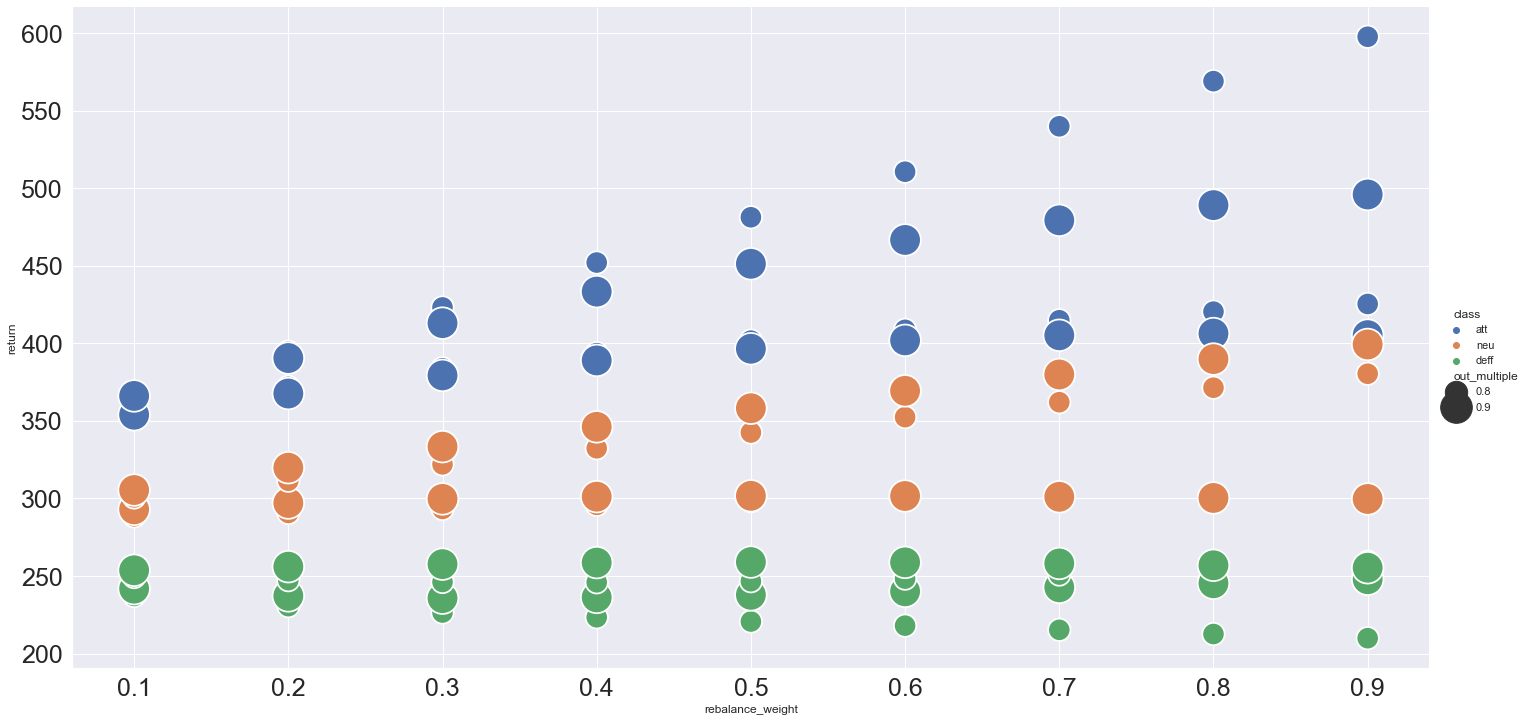

In [410]:
sns.relplot(
    data=rb_bt_stats[(rb_bt_stats['out_multiple'] > 0.7) & (rb_bt_stats['resid_diff'] > 10)], 
    x='rebalance_weight', y='return', kind='scatter', 
    hue='class', 
    size='out_multiple', sizes=(500, 1000), 
    height=10, aspect=2
)

In [173]:
rb_bt_stats[(rb_bt_stats['class'] == 'deff') & (rb_bt_stats['resid_diff'] == 20)].sort_values('return', ascending=False)

class      return  rb_count  resid_diff  out_multiple  rebalance_weight
539  deff  259.173883        34          20           0.8               0.9
554  deff  259.001733        24          20           0.9               0.5
557  deff  258.795883        24          20           0.9               0.6
551  deff  258.645459        24          20           0.9               0.4
560  deff  258.089430        24          20           0.9               0.7
548  deff  257.658686        24          20           0.9               0.3
563  deff  256.911841        24          20           0.9               0.8
545  deff  256.011979        24          20           0.9               0.2
566  deff  255.320074        24          20           0.9               0.9
536  deff  254.550909        34          20           0.8               0.8
542  deff  253.677521        24          20           0.9               0.1
533  deff  250.931973        34          20           0.8               0.7
515  deff  249.326961        34          20           0.8               0.1
434  deff  248.891499        70          20           0.4               0.1
530  deff  248.301998        34          20           0.8               0.6
518  deff  247.292512        34          20           0.8               0.2
527  deff  246.628624        34          20           0.8               0.5
521  deff  246.145857        34          20           0.8               0.3
524  deff  245.926630        34          20           0.8               0.4
437  deff  244.277317        70          20           0.4               0.2
407  deff  241.609152        68          20           0.3               0.1
488  deff  240.783277        57          20           0.6               0.1
440  deff  237.528511        70          20           0.4               0.3
380  deff  235.467131        68          20           0.2               0.1
410  deff  235.427969        68          20           0.3               0.2
461  deff  235.353642        66          20           0.5               0.1
491  deff  234.753829        57          20           0.6               0.2
413  deff  230.555441        68          20           0.3               0.3
443  deff  229.953151        70          20           0.4               0.4
494  deff  229.874098        57          20           0.6               0.3
383  deff  227.439203        68          20           0.2               0.2
416  deff  226.576515        68          20           0.3               0.4
497  deff  225.070304        57          20           0.6               0.4
464  deff  223.863563        66          20           0.5               0.2
419  deff  223.157088        68          20           0.3               0.5
386  deff  222.579732        68          20           0.2               0.3
446  deff  222.319232        70          20           0.4               0.5
422  deff  220.188706        68          20           0.3               0.6
500  deff  219.769976        57          20           0.6               0.5
389  deff  219.285570        68          20           0.2               0.4
425  deff  217.541548        68          20           0.3               0.7
392  deff  216.761276        68          20           0.2               0.5
428  deff  215.233096        68          20           0.3               0.8
449  deff  215.043807        70          20           0.4               0.6
395  deff  214.633342        68          20           0.2               0.6
467  deff  214.365697        66          20           0.5               0.3
503  deff  213.816907        57          20           0.6               0.6
431  deff  213.231840        68          20           0.3               0.9
398  deff  212.769675        68          20           0.2               0.7
401  deff  211.172197        68          20           0.2               0.8
404  deff  209.777815        68          20           0.2               0.9
452  deff  208.315032        70          20         

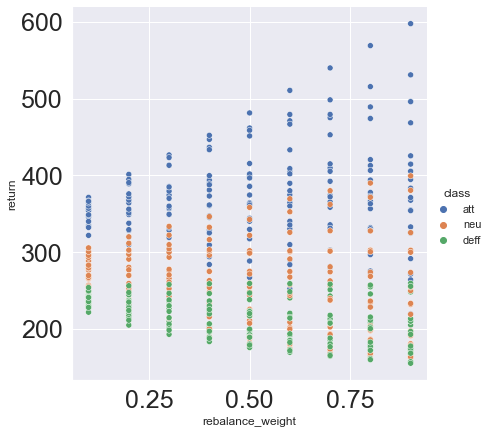

In [344]:
sns.relplot(
    data=rb_bt_stats, 
    x='rebalance_weight', y='return', kind='scatter', 
    hue='class', 
    # size='out_multiple', sizes=(20, 100), 
    height=6, 
)

# app.py

## 뷰안1

In [220]:
# 1번 박스 도넛차트
np.mean(glide_weight_att)

0.8407272727272729

In [221]:
# 1번 박스 선 차트
glide_weight_att

[1.0, 1.0, 1.0, 1.0, 0.953, 0.882, 0.831, 0.747, 0.678, 0.611, 0.546]

In [222]:
# 2번 박스 도넛차트
np.mean(glide_weight_neu)

0.6618181818181819

In [223]:
# 2번 박스 선 차트
glide_weight_neu

[0.76, 0.76, 0.735, 0.71, 0.685, 0.66, 0.638, 0.616, 0.594, 0.572, 0.55]

In [224]:
# 3번 박스 도넛차트
np.mean(glide_weight_def)

0.5329090909090909

In [225]:
# 3번 박스 선 차트
glide_weight_def

[0.71, 0.71, 0.67, 0.627, 0.583, 0.537, 0.485, 0.433, 0.393, 0.366, 0.348]

In [226]:
# 5번 박스 도넛차트
# 독일, 홍콩, 일본, 프랑스, 한국, S&P500, NASDAQ 순서
risk_weight

[0.025, 0.025, 0.0375, 0.0375, 0.25, 0.2, 0.425]

In [227]:
# 6번 박스 산점도 준비중

## 뷰안2

In [228]:
# 1번 박스 선 차트
bench_view2_1_att = bench_hv.loc[:, 'bench_att'].values.tolist() # [::20]
rb_view2_1_att    = bt_hv.loc[start_date_bt:, 'bt_att'].values.tolist()
bench_view2_1_neu = bench_hv.loc[:, 'bench_neu'].values.tolist() # [::20]
rb_view2_1_neu    = bt_hv.loc[start_date_bt:, 'bt_neu'].values.tolist()
bench_view2_1_def = bench_hv.loc[:, 'bench_def'].values.tolist() # [::20]
rb_view2_1_def    = bt_hv.loc[start_date_bt:, 'bt_def'].values.tolist()

In [318]:
bench_hv

bench_att   bench_neu   bench_def  bench_att_HV  \
2011-09-29  100.000000  100.000000  100.000000      0.000000   
2011-09-30   96.894450   97.729401   97.903692      0.246495   
2011-10-03   94.167313   95.755096   96.086552      0.222311   
2011-10-04   96.395743   97.374261   97.578528      0.355046   
2011-10-05   98.063501   98.560732   98.664513      0.358458   
...                ...         ...         ...           ...   
2021-08-23  336.107761  283.306716  248.580658      0.061779   
2021-08-24  337.321328  284.252686  249.027577      0.061111   
2021-08-25  337.413535  284.297495  248.903252      0.060327   
2021-08-26  335.691156  282.924752  248.092116      0.062003   
2021-08-27  338.341933  285.081231  249.596845      0.065144   

            bench_att_HV_pred_5  bench_att_HV_pred_10  bench_att_HV_pred_15  \
2011-09-29             0.360796              0.324120              0.305722   
2011-09-30             0.335630              0.316655              0.303504   
2011-10-03             0.372743              0.323141              0.303095   
2011-10-04             0.352095              0.317429              0.307939   
2011-10-05             0.338131              0.313585              0.300349   
...                         ...                   ...                   ...   
2021-08-23             0.065352              0.062779              0.066850   
2021-08-24             0.062112              0.063081              0.061912   
2021-08-25             0.063101              0.064279              0.062211   
2021-08-26             0.062585              0.065887              0.066675   
2021-08-27             0.061158              0.066630              0.080119   

            bench_att_HV_pred_20  bench_att_HV_resid_5  bench_att_HV_resid_10  \
2011-09-29              0.329484             -0.360796              -0.324120   
2011-09-30              0.302691             -0.089134              -0.070160   
2011-10-03              0.305007             -0.150432              -0.100830   
2011-10-04              0.318359              0.002951               0.037617   
2011-10-05              0.318000              0.020328               0.044873   
...                          ...                   ...                    ...   
2021-08-23              0.074235             -0.003572              -0.001000   
2021-08-24              0.077053             -0.001001              -0.001971   
2021-08-25              0.082518             -0.002774              -0.003953   
2021-08-26              0.081647             -0.000582              -0.003884   
2021-08-27              0.076160              0.003987              -0.001486   

            ...  bench_neu_HV_resid_20  bench_def_HV  bench_def_HV_pred_5  \
2011-09-29  ...              -0.243648      0.000000             0.240327   
2011-09-30  ...              -0.043592      0.166389             0.224015   
2011-10-03  ...              -0.065347      0.148701             0.252210   
2011-10-04  ...               0.019176      0.235603             0.238040   
2011-10-05  ...               0.020810      0.237141             0.228639   
...         ...                    ...           ...                  ...   
2021-08-23  ...              -0.011705      0.041410             0.045991   
2021-08-24  ...              -0.015018      0.041283             0.043730   
2021-08-25  ...              -0.020631      0.040595             0.044427   
2021-08-26  ...              -0.018245      0.041777             0.044334   
2021-08-27  ...              -0.009533      0.045832             0.041672   

            bench_def_HV_pred_10  bench_def_HV_pred_15  bench_def_HV_pred_20  \
2011-09-29              0.219153              0.207622              0.225634   
2011-09-30              0.214404              0.206888              0.207246   
2011-10-03              0.218676              0.207005              0.210158   
2011-10-04              0.215161              0.209926              0.219600 

In [229]:
# 2번 박스 선 차트
bench_view2_2_att = bench_hv.loc[:, 'bench_att_HV'].values.tolist() # [::20]
rb_view2_2_att    = (bt_hv.loc[:, 'bt_att'].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252))[1:].values.tolist()
bench_view2_2_neu = bench_hv.loc[:, 'bench_neu_HV'].values.tolist() # [::20]
rb_view2_2_neu    = (bt_hv.loc[:, 'bt_neu'].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252))[1:].values.tolist()
bench_view2_2_def = bench_hv.loc[:, 'bench_def_HV'].values.tolist() # [::20]
rb_view2_2_def    = (bt_hv.loc[:, 'bt_def'].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252))[1:].values.tolist()

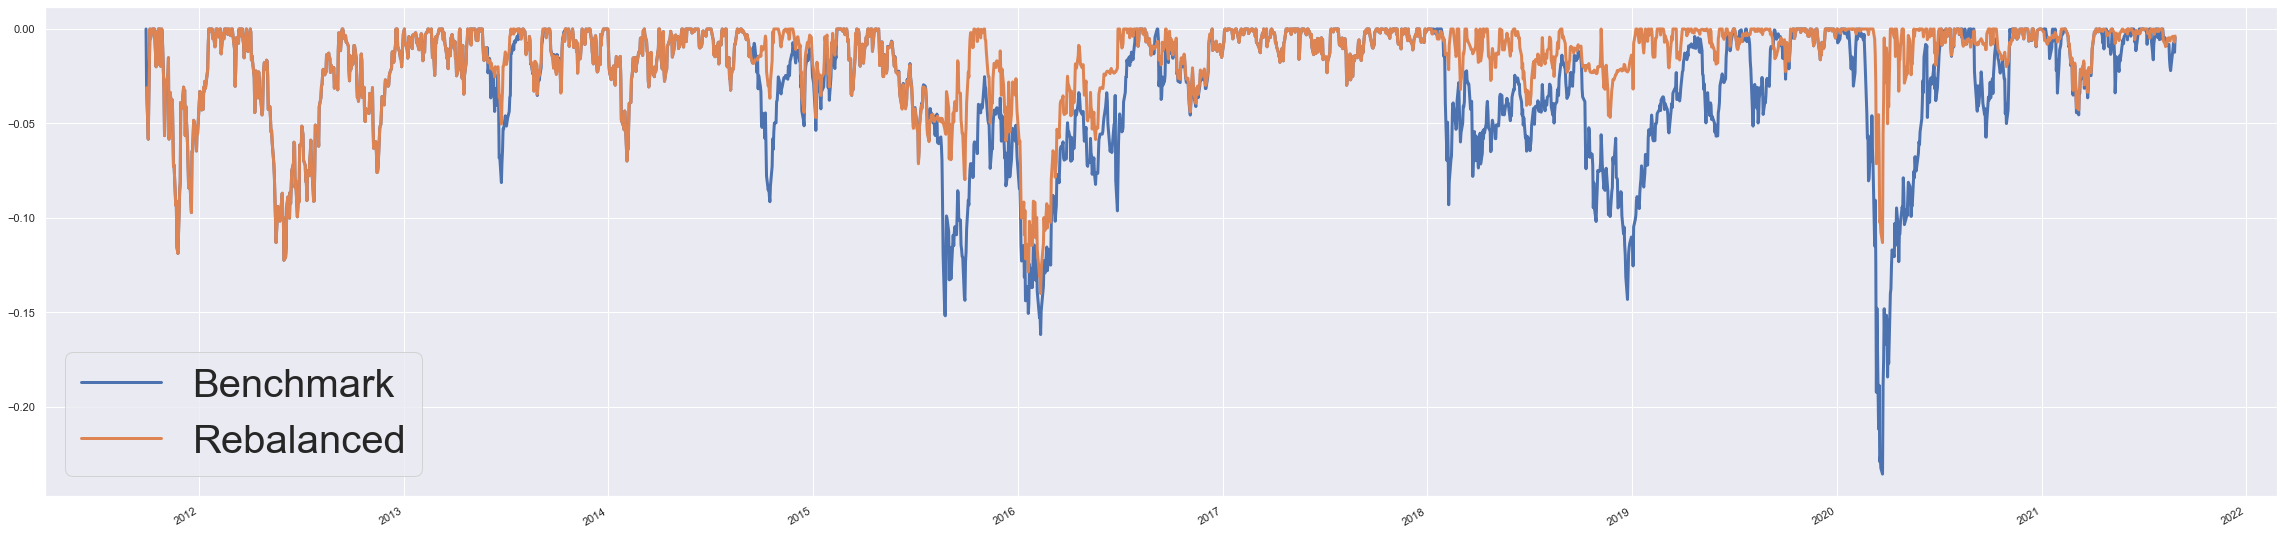

In [412]:
sns.set()

# 3번 박스 선 차트 : 공격형
pd.concat(
    [
        bench_hv['bench_att'].to_drawdown_series(), 
        bt_hv['bt_att'].to_drawdown_series()[1:]
    ], axis=1
).plot(figsize=(40, 10), lw=3)
plt.rc(['xtick', 'ytick'], labelsize=20)
plt.legend(fontsize=(40), labels=['Benchmark', 'Rebalanced'])

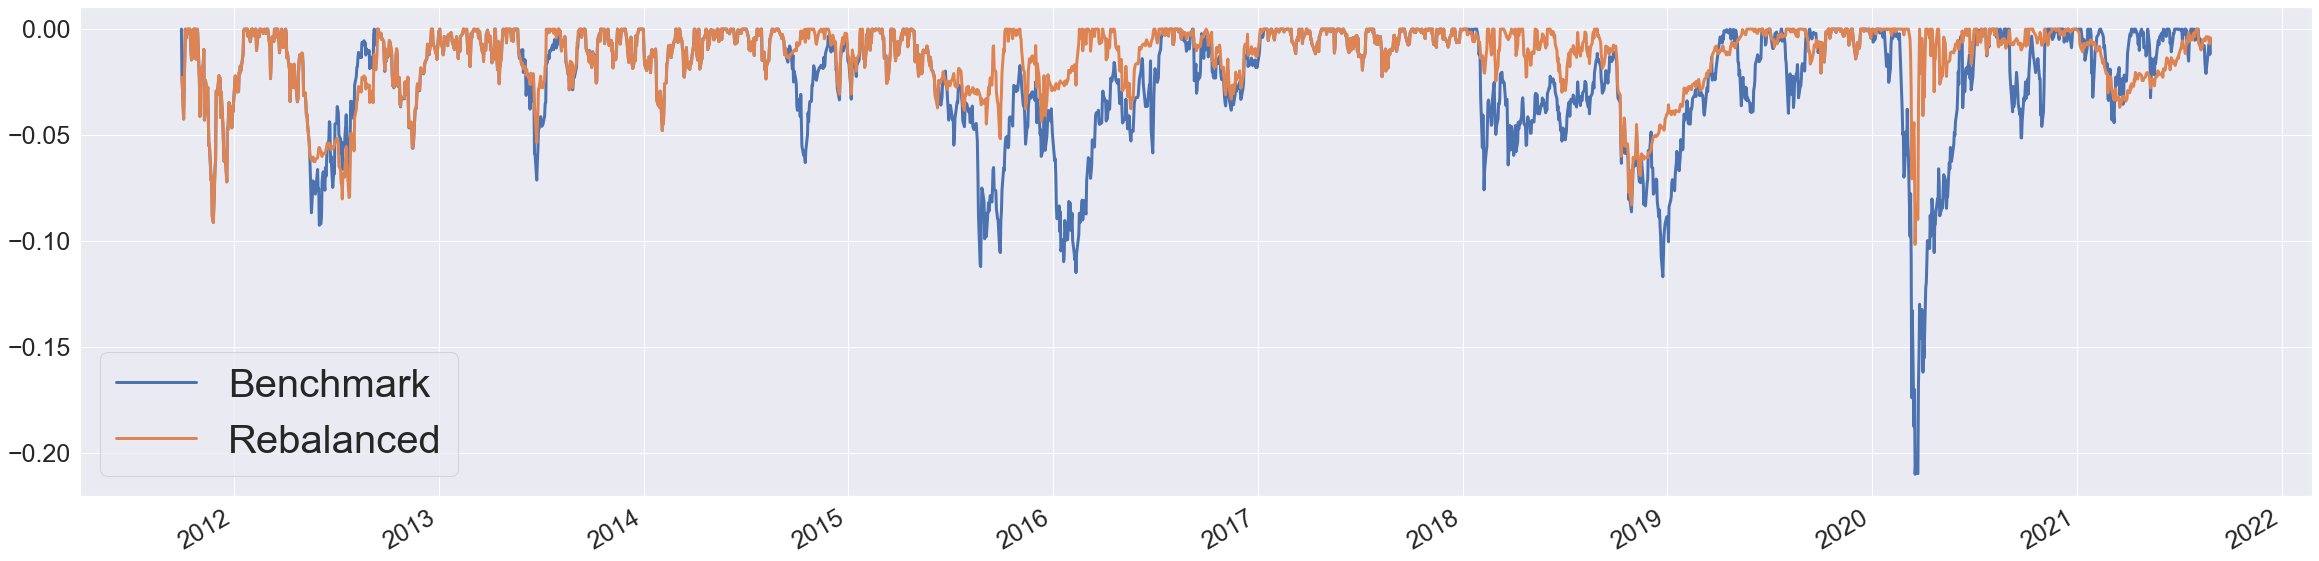

In [411]:
# 3번 박스 선 차트 : 중립형
pd.concat(
    [
        bench_hv['bench_neu'].to_drawdown_series(), 
        bt_hv['bt_neu'].to_drawdown_series()[1:]
    ], axis=1
).plot(figsize=(40, 10), lw=3)
plt.rc(['xtick', 'ytick'], labelsize=20)
plt.legend(fontsize=(40), labels=['Benchmark', 'Rebalanced'])

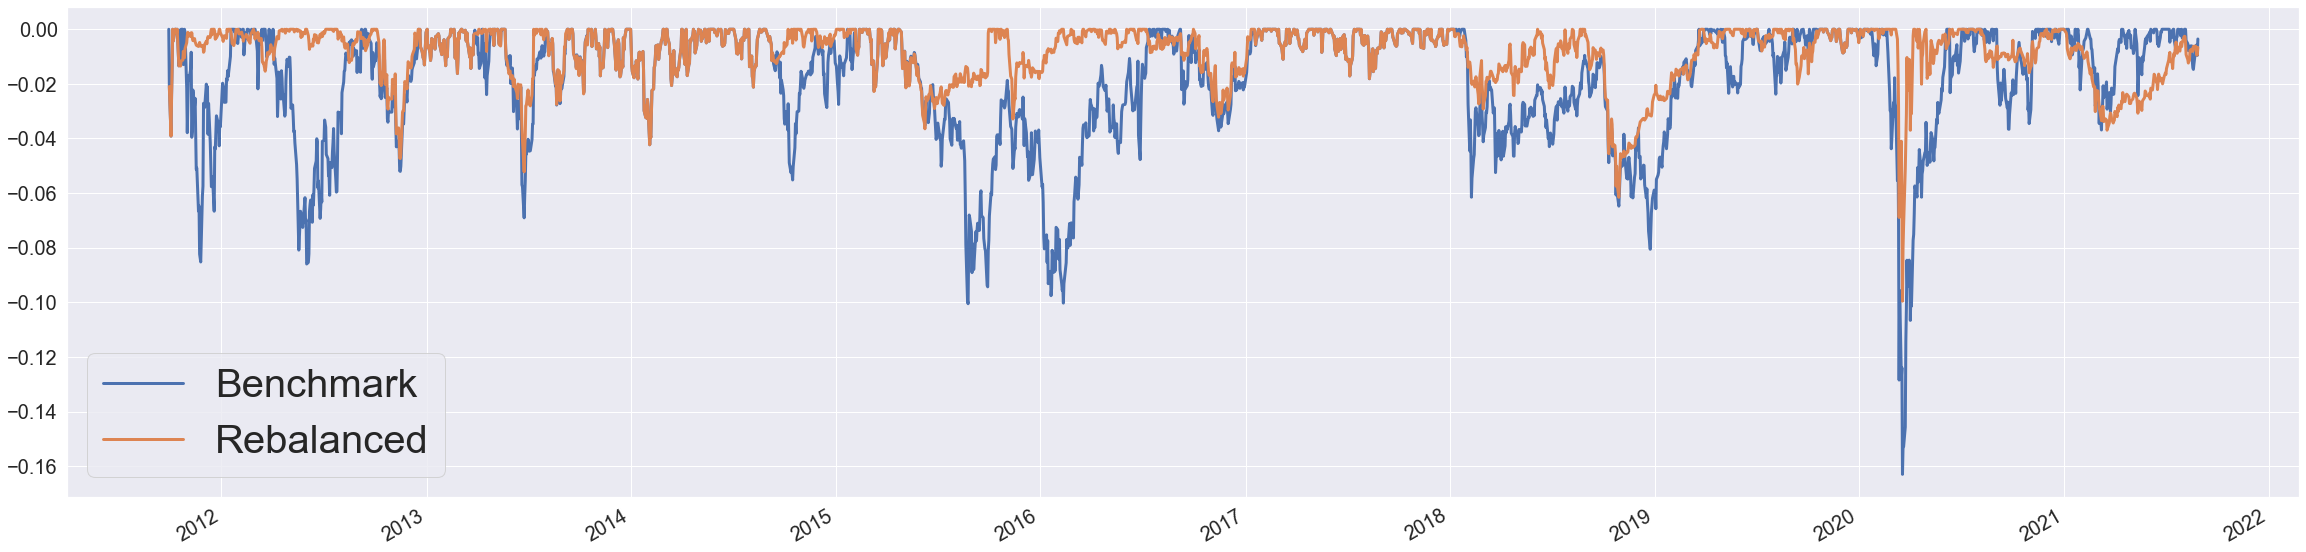

In [413]:
# 3번 박스 선 차트 : 방어형
pd.concat(
    [
        bench_hv['bench_def'].to_drawdown_series(), 
        bt_hv['bt_def'].to_drawdown_series()[1:]
    ], axis=1
).plot(figsize=(40, 10), lw=3)
plt.rc(['xtick', 'ytick'], labelsize=20)
plt.legend(fontsize=(40), labels=['Benchmark', 'Rebalanced'])

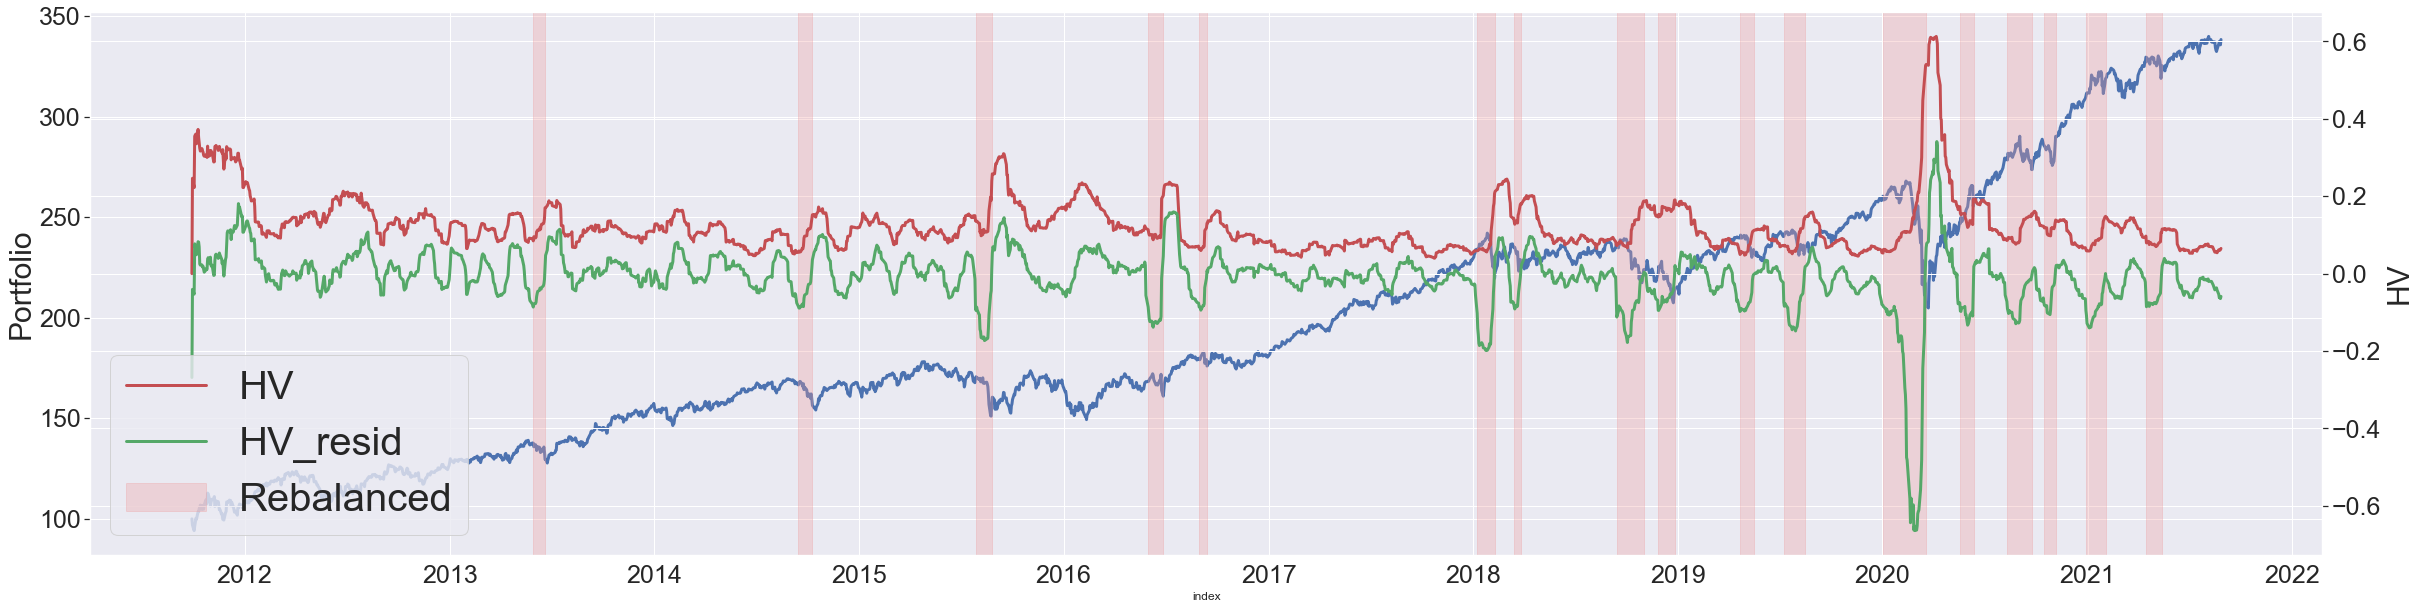

In [419]:
# 4번 박스 : 공격형 리밸런싱
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
sns.lineplot(ax=ax1, color='b', lw=3, y=history_bt_att['portfolio'], x=history_bt_att.index)
sns.lineplot(ax=ax2, color='r', lw=3, y=history_bt_att['HV'], x=history_bt_att.index)
sns.lineplot(ax=ax2, color='g', lw=3, y=history_bt_att['HV_resid'], x=history_bt_att.index)

out_idx_att = history_bt_att[history_bt_att['Fill_date'] == 'out'].index
in_idx_att  = history_bt_att[history_bt_att['Fill_date'] == 'in'].index
for i, j in zip(out_idx_att, in_idx_att):
    ax2.axvspan(i, j, color='#EF9A9A', alpha=0.3)
plt.rc(['xtick', 'ytick'], labelsize=20)
plt.legend(fontsize=40, labels=['HV', 'HV_resid', 'Rebalanced'])

ax1.set_ylabel('Portfolio', fontsize=30)
ax2.set_ylabel('HV', fontsize=30)
plt.rc(['xtick', 'ytick'], labelsize=25)
plt.show()

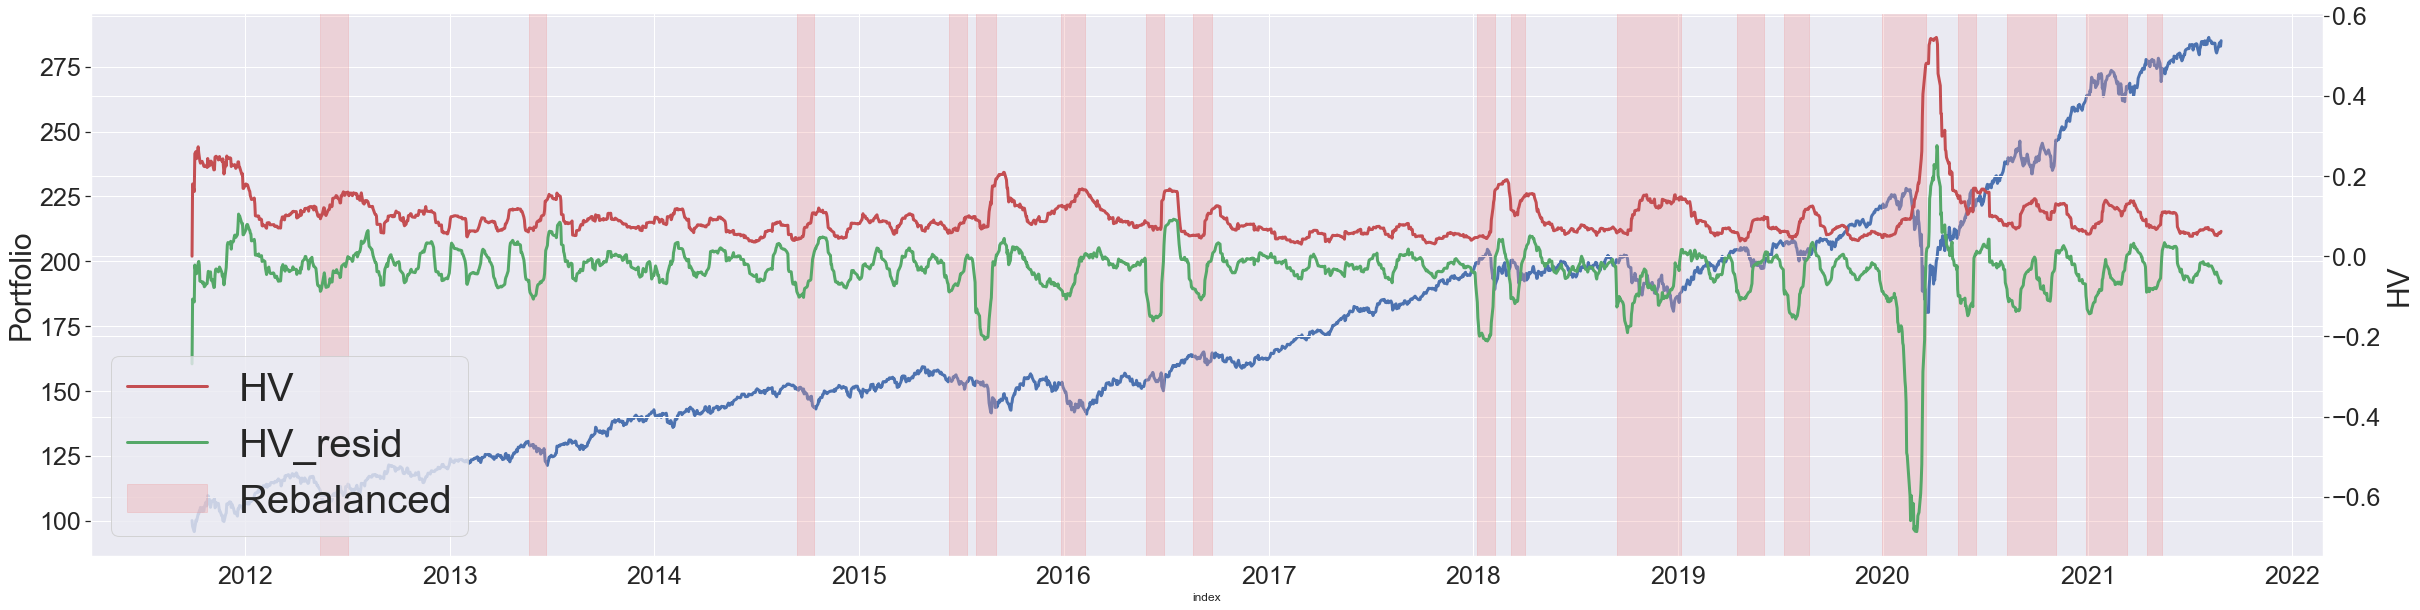

In [420]:
# 4번 박스 : 중립형 리밸런싱
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
sns.lineplot(ax=ax1, color='b', lw=3, y=history_bt_neu['portfolio'], x=history_bt_neu.index)
sns.lineplot(ax=ax2, color='r', lw=3, y=history_bt_neu['HV'], x=history_bt_neu.index)
sns.lineplot(ax=ax2, color='g', lw=3, y=history_bt_neu['HV_resid'], x=history_bt_neu.index)

out_idx_neu = history_bt_neu[history_bt_neu['Fill_date'] == 'out'].index
in_idx_neu  = history_bt_neu[history_bt_neu['Fill_date'] == 'in'].index
for i, j in zip(out_idx_neu, in_idx_neu):
    ax2.axvspan(i, j, color='#EF9A9A', alpha=0.3)
plt.rc(['xtick', 'ytick'], labelsize=20)
plt.legend(fontsize=(40), labels=['HV', 'HV_resid', 'Rebalanced'])

ax1.set_ylabel('Portfolio', fontsize=30)
ax2.set_ylabel('HV', fontsize=30)
plt.rc(['xtick', 'ytick'], labelsize=25)
plt.show()

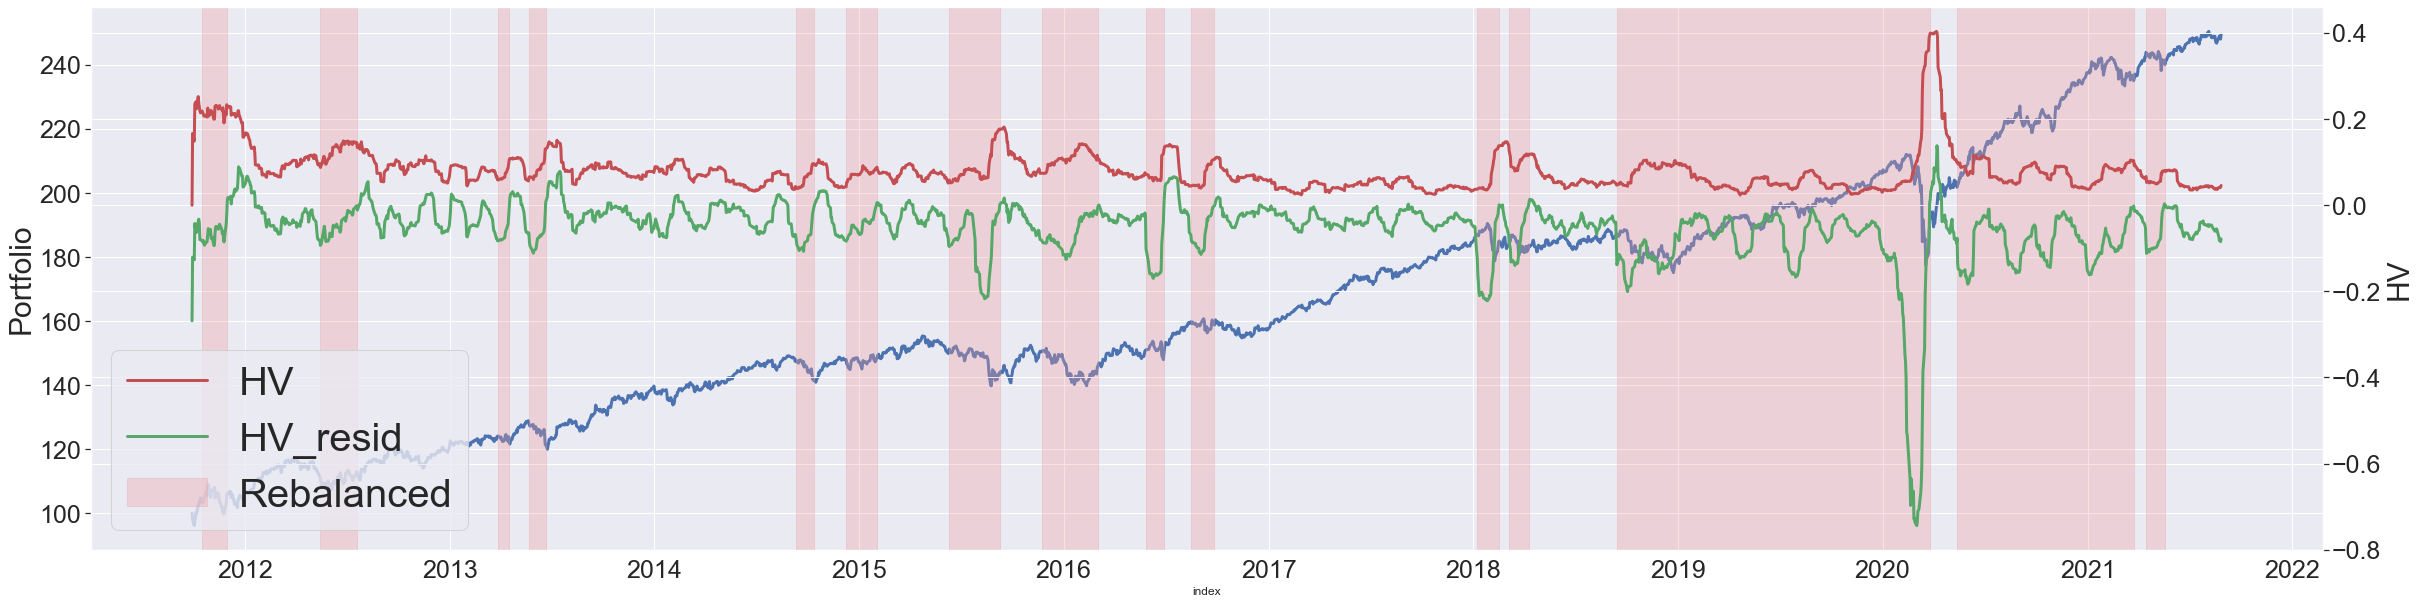

In [421]:
# 4번 박스 : 방어형 리밸런싱
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
sns.lineplot(ax=ax1, color='b', lw=3, y=history_bt_def['portfolio'], x=history_bt_def.index)
sns.lineplot(ax=ax2, color='r', lw=3, y=history_bt_def['HV'], x=history_bt_def.index)
sns.lineplot(ax=ax2, color='g', lw=3, y=history_bt_def['HV_resid'], x=history_bt_def.index)

out_idx_def = history_bt_def[history_bt_def['Fill_date'] == 'out'].index
in_idx_def  = history_bt_def[history_bt_def['Fill_date'] == 'in'].index
for i, j in zip(out_idx_def, in_idx_def):
    ax2.axvspan(i, j, color='#EF9A9A', alpha=0.3)
plt.rc(['xtick', 'ytick'], labelsize=20)
plt.legend(fontsize=(40), labels=['HV', 'HV_resid', 'Rebalanced'])

ax1.set_ylabel('Portfolio', fontsize=30)
ax2.set_ylabel('HV', fontsize=30)
plt.rc(['xtick', 'ytick'], labelsize=25)
plt.show()

In [310]:
# 5번, 6번 박스 방사형 수치
bench_view2_56_att = bench_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_mean', 'yearly_vol'], 'bench_att'].values.tolist()
rb_view2_56_att    = bt_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_mean', 'yearly_vol'], 'bt_att'].values.tolist()
bench_view2_56_neu = bench_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_mean', 'yearly_vol'], 'bench_neu'].values.tolist()
rb_view2_56_neu    = bt_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_mean', 'yearly_vol'], 'bt_neu'].values.tolist()
bench_view2_56_def = bench_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_mean', 'yearly_vol'], 'bench_def'].values.tolist()
rb_view2_56_def    = bt_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_mean', 'yearly_vol'], 'bt_def'].values.tolist()

total_result = pd.DataFrame(
    {
        'bench_att': bench_view2_56_att, 
        'rb_att': rb_view2_56_att, 
        'bench_neu': bench_view2_56_neu, 
        'rb_neu': rb_view2_56_neu, 
        'bench_def': bench_view2_56_def, 
        'rb_def': rb_view2_56_def
    }, 
    index=['Total Return', 'CAGR', 'MDD', 'CALMR', 'Yearly Sharpe', 'Yearly Mean', 'Yearly Vol']
)
total_result

bench_att    rb_att  bench_neu    rb_neu  bench_def    rb_def
Total Return    2.282253  4.976419   1.768583  2.803903   1.438970  1.591739
CAGR            0.126186  0.197621   0.107184  0.144268   0.093240  0.100827
MDD            -0.235533 -0.139998  -0.209965 -0.101554  -0.163010 -0.099599
CALMR           0.535747  1.411605   0.510483  1.420605   0.571988  1.012325
Yearly Sharpe   1.124312  1.809299   1.169586  1.700692   1.213736  1.377005
Yearly Mean     0.124057  0.192434   0.104789  0.139715   0.090151  0.096361
Yearly Vol      0.110340  0.106358   0.089595  0.082152   0.074276  0.069979

In [312]:
total_result.reset_index(inplace=True)

In [316]:
total_result.rename(columns={'index': 'ind'}, inplace=True)

In [321]:
total_result[['bench_att', 'rb_att', 'bench_neu', 'rb_neu', 'bench_def', 'rb_def']] = np.round(total_result[['bench_att', 'rb_att', 'bench_neu', 'rb_neu', 'bench_def', 'rb_def']], 4)
total_result

ind  bench_att  rb_att  bench_neu  rb_neu  bench_def  rb_def
0   Total Return     2.2823  4.9764     1.7686  2.8039     1.4390  1.5917
1           CAGR     0.1262  0.1976     0.1072  0.1443     0.0932  0.1008
2            MDD    -0.2355 -0.1400    -0.2100 -0.1016    -0.1630 -0.0996
3          CALMR     0.5357  1.4116     0.5105  1.4206     0.5720  1.0123
4  Yearly Sharpe     1.1243  1.8093     1.1696  1.7007     1.2137  1.3770
5    Yearly Mean     0.1241  0.1924     0.1048  0.1397     0.0902  0.0964
6     Yearly Vol     0.1103  0.1064     0.0896  0.0822     0.0743  0.0700

In [337]:
# total_result.to_csv('./result.csv')

In [325]:
bt_hv

bt_att      bt_neu      bt_def
2011-09-28  100.000000  100.000000  100.000000
2011-09-29  100.000000  100.000000  100.000000
2011-09-30   96.894450   97.729401   97.903692
2011-10-03   94.167313   95.755096   96.086552
2011-10-04   96.395743   97.374261   97.578528
...                ...         ...         ...
2021-08-23  597.563185  380.585000  259.301201
2021-08-24  596.958858  380.029398  258.928421
2021-08-25  595.947922  379.309251  258.437495
2021-08-26  595.714801  379.340594  258.459600
2021-08-27  597.641935  380.390346  259.173883

[2496 rows x 3 columns]

In [326]:
bt_hv['bt_att_hv'] = bt_hv.loc[:, 'bt_att'].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252)
bt_hv['bt_neu_hv'] = bt_hv.loc[:, 'bt_neu'].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252)
bt_hv['bt_def_hv'] = bt_hv.loc[:, 'bt_def'].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252)

In [331]:
bt_hv = bt_hv[1:]

In [332]:
bench_hv[['bench_att', 'bench_neu', 'bench_def', 'bench_att_HV', 'bench_neu_HV', 'bench_def_HV']]

bench_att   bench_neu   bench_def  bench_att_HV  bench_neu_HV  \
2011-09-29  100.000000  100.000000  100.000000      0.000000      0.000000   
2011-09-30   96.894450   97.729401   97.903692      0.246495      0.180223   
2011-10-03   94.167313   95.755096   96.086552      0.222311      0.161364   
2011-10-04   96.395743   97.374261   97.578528      0.355046      0.256046   
2011-10-05   98.063501   98.560732   98.664513      0.358458      0.257921   
...                ...         ...         ...           ...           ...   
2021-08-23  336.107761  283.306716  248.580658      0.061779      0.058561   
2021-08-24  337.321328  284.252686  249.027577      0.061111      0.057982   
2021-08-25  337.413535  284.297495  248.903252      0.060327      0.057204   
2021-08-26  335.691156  282.924752  248.092116      0.062003      0.058817   
2021-08-27  338.341933  285.081231  249.596845      0.065144      0.062106   

            bench_def_HV  
2011-09-29      0.000000  
2011-09-30      0.166389  
2011-10-03      0.148701  
2011-10-04      0.235603  
2011-10-05      0.237141  
...                  ...  
2021-08-23      0.041410  
2021-08-24      0.041283  
2021-08-25      0.040595  
2021-08-26      0.041777  
2021-08-27      0.045832  

[2495 rows x 6 columns]

In [333]:
bt_hv

bt_att      bt_neu      bt_def  bt_att_hv  bt_neu_hv  \
2011-09-29  100.000000  100.000000  100.000000   0.000000   0.000000   
2011-09-30   96.894450   97.729401   97.903692   0.246495   0.180223   
2011-10-03   94.167313   95.755096   96.086552   0.222311   0.161364   
2011-10-04   96.395743   97.374261   97.578528   0.355046   0.256046   
2011-10-05   98.063501   98.560732   98.664513   0.358458   0.257921   
...                ...         ...         ...        ...        ...   
2021-08-23  597.563185  380.585000  259.301201   0.026483   0.028205   
2021-08-24  596.958858  380.029398  258.928421   0.026048   0.027470   
2021-08-25  595.947922  379.309251  258.437495   0.026255   0.027869   
2021-08-26  595.714801  379.340594  258.459600   0.025997   0.027418   
2021-08-27  597.641935  380.390346  259.173883   0.028413   0.028786   

            bt_def_hv  
2011-09-29   0.000000  
2011-09-30   0.166389  
2011-10-03   0.148701  
2011-10-04   0.235603  
2011-10-05   0.237141  
...               ...  
2021-08-23   0.028090  
2021-08-24   0.027369  
2021-08-25   0.027768  
2021-08-26   0.027327  
2021-08-27   0.028715  

[2495 rows x 6 columns]

In [338]:
# pd.concat(
#     [
#         bench_hv[['bench_att', 'bench_neu', 'bench_def', 'bench_att_HV', 'bench_neu_HV', 'bench_def_HV']],
#         bt_hv
#     ], axis=1
# ).to_csv('./returns_hv.csv')